In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing


import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os
import torch.nn.utils.weight_norm as weight_norm

from sklearn.metrics import fbeta_score

import colorcet as cc

import seaborn as sns

from matplotlib_venn import venn3, venn2

# from torch.cuda.amp import GradScaler, autocast

torch.cuda.set_device(3)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
# !ls ../real_data

# torch.autograd.set_detect_anomaly(True)
import matplotlib
from matplotlib.pyplot import rc_context
matplotlib.rcParams['patch.edgecolor'] = 'black'

from captum.attr import Saliency, NoiseTunnel, LRP, GuidedBackprop, DeepLiftShap, DeepLift, IntegratedGradients

########## NEURAL NETWORK UTILITY ##########
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

CPUTensor =  torch.FloatTensor

from sklearn.preprocessing import StandardScaler

In [2]:
from matplotlib_venn import venn3

In [3]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [6]:
model = "genex"

adata_int = sc.read_h5ad('%s_simulation_1_temp.h5ad' % (model))

# adata_int.var.index = adata_int.var["gene_name"]

adata_int

AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Batch_colors', 'Group_num_colors', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [7]:
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

In [8]:
# assume that "sample_id" is a categorical annotation in `adata.obs`
# temp_df = {"0": "10X 3'", "1": "10X 5'"}

# adata_int.obs["batch"] = adata_int.obs["batch"].cat.rename_categories(temp_df)

In [9]:
adata_int.obs["Batch"]

Cell1       0
Cell2       0
Cell3       0
Cell4       0
Cell5       0
           ..
Cell7995    3
Cell7997    3
Cell7998    3
Cell7999    3
Cell8000    3
Name: Batch, Length: 7891, dtype: category
Categories (4, object): ['0', '1', '2', '3']

In [10]:
# fig, ax = plt.subplots(figsize=(8, 6))

# legend_loc='lower center'
# legend_ncol=1
# color = "CellType"
    
# sc.pl.umap(
#     adata_int,
#     color=color,
#     ax=ax,
#     show=False,
#     legend_loc=False,
#     legend_fontsize=12,
# )

# # Get unique labels and colors
# labels = adata_int.obs[color].cat.categories
# vals = set(adata_int.obs[color])
# custom_palette = cc.glasbey_category10 * len(vals)
# colors = custom_palette

# # Create custom legend without title
# handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markeredgecolor='black', markeredgewidth=1,
#                       markerfacecolor=color, markersize=8) for label, color in zip(labels, colors)]
# legend = ax.legend(handles=handles, title = "Cell Type", loc=legend_loc, bbox_to_anchor=(0.5, -0.6), ncol=legend_ncol)

# # Adjust the figure's layout
# # plt.tight_layout(rect=[0, 0.1, 1, 1])

# plt.show()

In [11]:
# adding the scale value for heatmap and dotplot visualisation

adata_int.layers["X_raw_scaled"] = sc.pp.scale(adata_int.layers["X_raw"].copy(), copy = True)
adata_int.layers["X_corrected_scaled"] = sc.pp.scale(adata_int.obsm["X_latent"].copy(), copy = True)

In [12]:
# # subset to only two cell types that has subtle different which are acinar and ductal cell type
# subset_celltype = ["acinar", "ductal"]

# adata_int = adata_int[adata_int.obs["celltype"].isin(subset_celltype)].copy()

In [13]:
# # remove minority class as we have seen that 5 cell type are very rare
# counts = adata_int.obs["CellType"].value_counts()
# minority_classes = counts.index[-3:].tolist()        # get the minority classes
# adata_int = adata_int[                               # actually subset
#     ~adata_int.obs["CellType"].isin(minority_classes)]
# adata_int.obs["CellType"].cat.reorder_categories(       # reorder according to abundance
#     counts.index[:-3].tolist(), inplace=True)

In [14]:
adata_int.layers["X_corrected"] = adata_int.obsm["X_latent"].copy()

In [15]:
adata_int.obsm["X_latent"].copy()

array([[0.        , 0.        , 0.        , ..., 0.01223044, 0.        ,
        0.20111091],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13714172],
       [0.        , 0.        , 0.01620058, ..., 1.167726  , 0.        ,
        0.18007192],
       ...,
       [0.        , 0.        , 0.01585579, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [16]:
# temp_array = adata_int.layers["X_corrected"]
# temp_array[temp_array <= 0.5] = 0.

# adata_int.layers["X_corrected"] = temp_array

# temp_array

In [17]:
# split per batch into new objects.
batches = list(set(adata_int.obs['Batch']))
alldata = {}
for batch in batches:
    alldata[batch] = adata_int[adata_int.obs['Batch'] == batch,]

alldata    

{'1': View of AnnData object with n_obs × n_vars = 1982 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', 'louvain'
     var: 'n_cells'
     uns: 'Batch_colors', 'Group_num_colors', 'log1p', 'louvain', 'neighbors', 'umap'
     obsm: 'X_latent', 'X_pca', 'X_umap'
     layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
     obsp: 'connectivities', 'distances',
 '0': View of AnnData object with n_obs × n_vars = 993 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', 'louvain'
     var: 'n_cells'
     uns: 'Batch_colors', 'Group_num_colors', 'log1p', 'louvain', 'neighbors', 'umap'
     obsm: 'X_latent', 'X_pca', 'X_umap'
     layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
     obsp: 'connectivities', 'distances',
 '3': View of AnnData object with n_obs × n_vars = 2948 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize'

In [18]:
# get only the common cell type across all batches
common_celltype_list = []

for each in alldata:
    celltype_list = list(set(alldata[each].obs["Group"]))
    common_celltype_list.append(celltype_list)
    
common_celltype = list(set.intersection(*map(set,common_celltype_list)))

In [19]:
common_celltype.sort()

In [20]:
adata_int = adata_int[adata_int.obs["Group"].isin(common_celltype)].copy()

In [21]:
adata_int

AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Batch_colors', 'Group_num_colors', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
    obsp: 'connectivities', 'distances'

In [22]:
# adata_int.layers["X_raw"].toarray()

In [23]:
adata_int.layers["X_raw"]

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.1481607, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [24]:
adata_int.layers["X_corrected"]

array([[0.        , 0.        , 0.        , ..., 0.01223044, 0.        ,
        0.20111091],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13714172],
       [0.        , 0.        , 0.01620058, ..., 1.167726  , 0.        ,
        0.18007192],
       ...,
       [0.        , 0.        , 0.01585579, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [25]:
class GeneExpressionAttention(nn.Module):
    def __init__(self, n_features, d_k, bias = True):
        super(GeneExpressionAttention, self).__init__()
        self.d_k = d_k
        self.bias = bias
        
        # query representation
        self.W_Q = nn.Linear(n_features, d_k, self.bias)
        
        # key and value pair to attend to
        self.W_K = nn.Linear(n_features, d_k, self.bias)
        self.W_V = nn.Linear(n_features, d_k, self.bias)
        
        # multihead attention
#         self.multi_atten = nn.MultiheadAttention(d_k, 4, kdim = n_features, vdim = n_features, batch_first = True)

#         self.encoder = nn.GRU(n_features, d_k, num_layers = 1, bidirectional = False, batch_first = True)

    def forward(self, tabular_data):
        # Project tabular data into Q, K, and V matrices
        Q = self.W_Q(tabular_data)
        K = self.W_K(tabular_data)
        V = self.W_V(tabular_data)
        
        Q, K, V = Q.unsqueeze(1), K.unsqueeze(1), V.unsqueeze(1)
        
#         attn_output, attn_output_weights = self.multi_atten(Q, K, V)
        
#         return attn_output.squeeze(1)

        return F.scaled_dot_product_attention(Q,K,V, is_causal = True).squeeze(1)

class TrainableWeightedSum(nn.Module):
    def __init__(self):
        super(TrainableWeightedSum, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(2))  # Create learnable weights
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weights)  # Initialize weights with uniform distribution

    def forward(self, tensor1, tensor2):
        # Apply element-wise multiplication to the input tensors
        weighted_tensor1 = torch.mul(tensor1, self.weights[0])
        weighted_tensor2 = torch.mul(tensor2, self.weights[1])

        # Sum the weighted tensors
        fused_tensor = torch.add(weighted_tensor1, weighted_tensor2)

        return fused_tensor

class LinearAttention(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super(LinearAttention, self).__init__()
        
        self.feed_forward  = nn.Sequential(
            nn.Linear(in_features, in_features, bias),
            nn.ReLU(),
            nn.Linear(in_features, in_features, bias),
            nn.Dropout(0.1),
        )
        
        self.gamma = nn.Parameter(torch.zeros(1))  # Create learnable weights
        
        self.atten = GeneExpressionAttention(in_features, in_features, bias)
#         self.weighted_sum = TrainableWeightedSum()
#         self.weighted_sum.cuda()

        self.norm1 = nn.BatchNorm1d(in_features)
        self.norm2 = nn.BatchNorm1d(out_features)
        
        # Dropout
        self.dropout = nn.Dropout(0.1)
        
        # output layer
        
        self.out = nn.Linear(in_features, out_features, bias)

    def forward(self, x):
        atten_out = self.norm1(self.dropout(self.gamma * self.atten(x)) + x)
#         atten_out_2 = self.atten2(x)
        out = self.feed_forward(atten_out)
        out = atten_out + self.dropout(out)
        out = self.norm2(out)
        return self.out(out)

In [26]:
from utils.sophia import SophiaG
from utils.acprop import ACProp
# from pytorch_optimizer import *
from adabelief_pytorch import AdaBelief
from pytorch_optimizer import clip_grad_norm

In [27]:
label_str = "Batch"
group_str = "Group"

data_size = 4695
lr = 0.0001
b1 = 0.5
b2 = 0.999
latent_dim = 32
style_dim = latent_dim
embedding_dim = 16
n_dim = 1024
#     proj_dim = 2000
n_critic = 5
global c_dim, ctype_dim
c_dim = len(list(set(adata_int.obs[label_str])))
g_dim = len(list(set(adata_int.obs[group_str])))

act_func = nn.ReLU()

class Discriminator(nn.Module):
    def __init__(self, dropout_rate = 0.16):
        super(Discriminator, self).__init__()

#             self.self_att = nn.Sequential(
#                     GeneExpressionAttention(data_size, embedding_dim),
#                     LinearAttention(embedding_dim, embedding_dim),
#             )

        self.dropout_rate = dropout_rate

        self.model = nn.Sequential(
            GeneExpressionAttention(data_size, n_dim), # adding projection layer
            nn.BatchNorm1d(n_dim),
            nn.Dropout(self.dropout_rate),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(n_dim, n_dim // 2),
            nn.BatchNorm1d(n_dim // 2),
            nn.Dropout(self.dropout_rate),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(n_dim // 2, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(0.2, inplace = True),
        )

        # Output layers
        self.adv_layer = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, 1)
            ) for _ in range(c_dim + g_dim)
        ])

        # Classify layers
        self.cls_layer_c = nn.Sequential(
            nn.Linear(latent_dim, c_dim),
        )

        # classifying groups
        self.cls_layer_g = nn.Sequential(
            nn.Linear(latent_dim, g_dim),
        )

    def forward(self, data):
      #  data = torch.cat((data, label), -1)
#             atten = self.self_att(data)
        out = self.model(data)
#             out = self.residual(out)
        # shortcut connection with attention embeddings
#             out = combine(out, atten)
        validity = [adv(out) for adv in self.adv_layer]

        classify_c = self.cls_layer_c(out)
        classify_g = self.cls_layer_g(out)
        return classify_g
    
D_B = Discriminator()

In [28]:
D_B.load_state_dict(torch.load('Discriminator_rom_simulation_1.pth'))

<All keys matched successfully>

In [29]:
D_B.cpu()

Discriminator(
  (model): Sequential(
    (0): GeneExpressionAttention(
      (W_Q): Linear(in_features=4695, out_features=1024, bias=True)
      (W_K): Linear(in_features=4695, out_features=1024, bias=True)
      (W_V): Linear(in_features=4695, out_features=1024, bias=True)
    )
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.16, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.16, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_featu

In [30]:
raw_input = FloatTensor(adata_int.layers["X_raw"])

In [31]:
from sklearn.preprocessing import OneHotEncoder

# le = preprocessing.LabelEncoder()
enc_batch = OneHotEncoder(handle_unknown='ignore')
enc_group = OneHotEncoder(handle_unknown='ignore')

label_str = "Batch"
group_str = "Group"

enc_batch.fit(adata_int.obs[label_str].to_numpy().reshape(-1, 1))
enc_group.fit(adata_int.obs[group_str].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [32]:
batches

['1', '0', '3', '2']

In [33]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [34]:
D_B

Discriminator(
  (model): Sequential(
    (0): GeneExpressionAttention(
      (W_Q): Linear(in_features=4695, out_features=1024, bias=True)
      (W_K): Linear(in_features=4695, out_features=1024, bias=True)
      (W_V): Linear(in_features=4695, out_features=1024, bias=True)
    )
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.16, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.16, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_featu

In [35]:
D_B.cuda()
D_B.eval()
explainer = IntegratedGradients(D_B, False)

In [36]:
def create_mini_batches(data, batch_size):
    mini_batches = []
    n = len(data)
    for i in range(0, n, batch_size):
        mini_batch = data[i:i + batch_size]
        mini_batches.append(mini_batch)
    return mini_batches

In [37]:
def z_scale(matrix):
    """
    Scale a matrix column-wise.
    
    Parameters:
        matrix (numpy array): Matrix to be scaled.
        
    Returns:
        numpy array: Scaled matrix.
    """
    # Create an empty matrix to store the scaled data
    scaled_matrix = np.empty_like(matrix)
    
    # Iterate over the columns of the matrix
    for i in range(matrix.shape[1]):
        # Get the current column
        column = matrix[:, i]
        
        # Calculate the mean and standard deviation of the column
        mean = np.mean(column)
        std = np.std(column)
        
        # Scale the column
        scaled_column = (column - mean) / std
        
        # Store the scaled column in the scaled matrix
        scaled_matrix[:, i] = scaled_column
        
    return scaled_matrix

In [38]:
def filter_genes_by_expression(df, threshold, genes_as_rows=False):
    """
    Filters out genes that have a low proportion of cells expressing them.

    Args:
        df (pd.DataFrame): Input dataframe with genes as columns and cells as rows (or vice versa if genes_as_rows=True).
        threshold (float): Proportion threshold (0 to 1) for filtering genes.
        genes_as_rows (bool): Set to True if the input dataframe has genes as rows and cells as columns. Default is False.

    Returns:
        pd.DataFrame: Filtered dataframe containing only genes that have a proportion of cells expressing them above the threshold.
    """

    # Transpose the dataframe if genes are given as rows
    if genes_as_rows:
        df = df.T

    # Calculate the proportion of cells expressing each gene
    proportion = (df > 0).sum() / len(df)

    # Filter out genes with a proportion of cells below the threshold
    filtered_genes = proportion[proportion >= threshold].index
    filtered_df = df.loc[:, filtered_genes]

    return filtered_df

In [39]:
# Set your confidence threshold
confidence_threshold = 0.8

# Create a function to get high-confidence instances
def get_high_confidence_indices(output_probs, threshold):
    max_probs, _ = torch.max(output_probs, dim=1)
    high_confidence_indices = (max_probs >= threshold).nonzero(as_tuple=True)[0]
    return high_confidence_indices

raw_input = FloatTensor(adata_int.layers["X_raw"])

# Get output probabilities
output_probs = torch.softmax(D_B(raw_input), dim=1)

# Get high-confidence instances
high_confidence_indices = get_high_confidence_indices(output_probs, confidence_threshold)

# Filter input data based on high-confidence instances
raw_input_high_confidence = raw_input[high_confidence_indices]

# subset the big dataset into only a highly confidence prediction
adata_int = adata_int[high_confidence_indices.detach().cpu().numpy()]
raw_input = FloatTensor(adata_int.layers["X_raw"])

In [40]:
# D_B = nn.DataParallel(D_B)

# D_B.to(device)
# raw_input.to(device)
# D_B.cpu()

saliency_map_0_list = []
raw_input_list = create_mini_batches(raw_input, 1024)

for sub_raw_input in raw_input_list:
    saliency_map_0 = np.round(explainer.attribute(sub_raw_input.detach(), target = 0, n_steps = 100).cpu().detach().numpy(), 5)
    saliency_map_0_list.append(saliency_map_0)
    torch.cuda.empty_cache()
saliency_map_0 = np.concatenate(saliency_map_0_list)

In [41]:
saliency_map_0.shape

(7868, 4695)

In [42]:
adata_int.obs["Group_num"]

Cell1       Group1
Cell2       Group2
Cell3       Group1
Cell4       Group1
Cell5       Group1
             ...  
Cell7995    Group1
Cell7997    Group1
Cell7998    Group1
Cell7999    Group1
Cell8000    Group2
Name: Group_num, Length: 7868, dtype: category
Categories (2, object): ['Group1', 'Group2']

In [43]:
three_prime_df = pd.DataFrame(saliency_map_0)
three_prime_df.columns = adata_int.var.index
three_prime_df.index = adata_int.obs.index
# three_prime_df.to_csv("saliency_map_3prime.csv", index = True)

# filter the dataframe so that it is only specific to celltype only
masked = adata_int.obs["Group"] == 0
# three_prime_df_scaled = three_prime_df_scaled[masked]
three_prime_df = three_prime_df[masked]

# filtering out the gene with fewer number of cell so that we dont get the heavy value with small cell population
temp_df = pd.DataFrame(np.array(adata_int.layers["X_raw"]), index = adata_int.obs.index, columns = adata_int.var.index)
temp_df = temp_df[masked]
gene_filtered = filter_genes_by_expression(temp_df, 0.000001).columns

three_prime_df = three_prime_df[gene_filtered]

# three_prime_df_scaled = pd.DataFrame(z_scale(three_prime_df.values), columns=three_prime_df.columns, index = three_prime_df.index)

# three_prime_df_scaled["CellType"] = adata_int.obs.CellType
three_prime_df["Group"] = adata_int.obs.Group

In [44]:
# three_prime_df.groupby("CellType").mean().round(5).to_csv("IG_3prime_by_celltype_non_normalise.csv")

In [45]:
avg_3_df = three_prime_df.groupby("Group").mean()

In [46]:
top_100_3 = avg_3_df.mean().sort_values(ascending=False)[:50].index

In [47]:
top_100_3

Index(['Gene4959', 'Gene1964', 'Gene1234', 'Gene263', 'Gene3186', 'Gene4801',
       'Gene1131', 'Gene4831', 'Gene3986', 'Gene195', 'Gene1524', 'Gene2319',
       'Gene2235', 'Gene2843', 'Gene3383', 'Gene2617', 'Gene1607', 'Gene1419',
       'Gene2345', 'Gene2979', 'Gene3666', 'Gene3262', 'Gene3701', 'Gene3527',
       'Gene4496', 'Gene802', 'Gene189', 'Gene472', 'Gene4857', 'Gene1424',
       'Gene2891', 'Gene1698', 'Gene2935', 'Gene216', 'Gene1062', 'Gene406',
       'Gene599', 'Gene3512', 'Gene1617', 'Gene4395', 'Gene1275', 'Gene2352',
       'Gene517', 'Gene1538', 'Gene3773', 'Gene765', 'Gene3602', 'Gene2969',
       'Gene2380', 'Gene731'],
      dtype='object')

In [48]:
# sub_adata = adata_int[:, top_100_3]

In [49]:
# sc.pl.heatmap(sub_adata, top_100_3, groupby = "CellType", show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [50]:
# sc.pl.heatmap(sub_adata, top_100_3, groupby = "CellType", show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [51]:
# sc.pl.heatmap(sub_adata, top_100_3, groupby = ["CellType", "Method"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [52]:
# sc.pl.heatmap(sub_adata, top_100_3, groupby = ["CellType", "Method"], show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [53]:
# sub_adata_3 = sub_adata[sub_adata.obs.batch == "0"]
# sub_adata_3

In [54]:
# sc.pl.heatmap(sub_adata_3, top_100_3, groupby = ["CellType"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [55]:
# adata_int 

In [56]:
# celltype_list = list(avg_3_df.index)
# top_genes = {}

# for celltype in celltype_list:
#     top_genes[celltype] = list(avg_3_df.loc[celltype].sort_values(ascending=False)[:10].index)
    
# sc.pl.heatmap(adata_int, top_genes, groupby = ["CellType", "batch"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

# Discover top genes for each cell type

In [57]:
# celltype_list = list(avg_3_df.index)
# top_genes = {}

# for celltype in celltype_list:
#     top_genes[celltype] = list(avg_3_df.loc[celltype].sort_values(ascending=False)[:10].index)
    
# sc.pl.heatmap(adata_int, top_genes, groupby = ["CellType", "batch"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [58]:
# sc.pl.heatmap(adata_int, top_genes, groupby = ["CellType", "batch"], show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [59]:
# generate metadata
# adata_int.obs.to_csv("metadata_pbmc.csv", index = True)

In [60]:
# clear GPU
import torch
torch.cuda.empty_cache()

In [61]:
# explainer = Saliency(model_wrapper)
# target = enc_batch.transform(np.array(["1"]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)

# create matrix for the target label that we want to see with the saliency map
# labels_ = [0.0]

# for each in range(c_dim - 1):
#     labels_.append(0.0)

# labels_ = np.array(labels_)

# labels_ = np.tile(labels_, (raw_input.shape[0], 1))

# trg_labels = Variable(CPUTensor(labels_))
    
# trg_labels[:, target] = 1.0

# saliency_map_1 = np.round(NormalizeData(nt.attribute(raw_input.detach(), additional_forward_args = trg_labels,
#                                 nt_type = "smoothgrad",
#                                 stdevs = 0.02,
#                                 draw_baseline_from_distrib = True,
#                                 nt_samples_batch_size = 50).detach().numpy()), 5)

# saliency_map_1 = np.round(NormalizeData(explainer.attribute(raw_input.detach(), additional_forward_args = trg_labels).detach().numpy()), 5)
saliency_map_1_list = []
raw_input_list = create_mini_batches(raw_input, 1024)

for sub_raw_input in raw_input_list:
    saliency_map_1 = np.round(explainer.attribute(sub_raw_input.detach(), target = 1, n_steps = 100).cpu().detach().numpy(), 5)
    saliency_map_1_list.append(saliency_map_1)
    torch.cuda.empty_cache()
saliency_map_1 = np.concatenate(saliency_map_1_list)

In [62]:
five_prime_df = pd.DataFrame(saliency_map_1)
five_prime_df.columns = adata_int.var.index
five_prime_df.index = adata_int.obs.index
# three_prime_df.to_csv("saliency_map_3prime.csv", index = True)

# filter the dataframe so that it is only specific to celltype only
masked = adata_int.obs["Group"] == 1
five_prime_df = five_prime_df[masked]

# filtering out the gene with fewer number of cell so that we dont get the heavy value with small cell population
temp_df = pd.DataFrame(np.array(adata_int.layers["X_raw"]), index = adata_int.obs.index, columns = adata_int.var.index)
temp_df = temp_df[masked]
gene_filtered = filter_genes_by_expression(temp_df, 0.1).columns

five_prime_df = five_prime_df[gene_filtered]

five_prime_df["Group"] = adata_int.obs.Group

In [63]:
# five_prime_df.groupby("CellType").mean().round(5).to_csv("IG_5prime_by_celltype_non_normalise.csv")

In [64]:
avg_5_df = five_prime_df.groupby("Group").mean()

In [65]:
top_100_5 = avg_5_df.mean().sort_values(ascending=False)[:50].index

In [66]:
top_100_5

Index(['Gene1199', 'Gene2636', 'Gene1332', 'Gene4490', 'Gene4906', 'Gene4191',
       'Gene4076', 'Gene1218', 'Gene1063', 'Gene1514', 'Gene3612', 'Gene2774',
       'Gene4166', 'Gene1156', 'Gene3971', 'Gene3311', 'Gene3805', 'Gene1456',
       'Gene1283', 'Gene1355', 'Gene2222', 'Gene859', 'Gene994', 'Gene2992',
       'Gene3151', 'Gene2374', 'Gene1777', 'Gene302', 'Gene2936', 'Gene4163',
       'Gene1270', 'Gene1742', 'Gene1667', 'Gene2238', 'Gene2521', 'Gene1543',
       'Gene2834', 'Gene3073', 'Gene1532', 'Gene411', 'Gene3726', 'Gene3222',
       'Gene911', 'Gene3174', 'Gene2094', 'Gene3157', 'Gene4169', 'Gene4945',
       'Gene3718', 'Gene3637'],
      dtype='object')

In [67]:
sub_adata = adata_int[:, top_100_5]

In [68]:
# sc.pl.heatmap(sub_adata, top_100_5, groupby = "CellType", show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [69]:
# sc.pl.heatmap(sub_adata, top_100_5, groupby = "CellType", show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [70]:
count = 0
for each in top_100_5:
    if each in top_100_3:
        count += 1

In [71]:
count

0

In [72]:
# sc.pl.heatmap(sub_adata, top_100_5, groupby = ["CellType", "Method"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [73]:
# sc.pl.heatmap(sub_adata, top_100_5, groupby = ["CellType", "Method"], show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [74]:
# pd.Series(top_100_3).to_csv("IG_top_100_3_non_normalise.csv")

In [75]:
# pd.Series(top_100_5).to_csv("IG_top_100_5_non_normalise.csv")

In [76]:
# celltype_list = list(avg_5_df.index)
# top_genes = {}

# for celltype in celltype_list:
#     top_genes[celltype] = list(avg_5_df.loc[celltype].sort_values(ascending=False)[:10].index)
    
# sc.pl.heatmap(adata_int, top_genes, groupby = ["CellType", "batch"], show_gene_labels=True, layer = "X_raw_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [77]:
# sc.pl.heatmap(adata_int, top_genes, groupby = ["CellType", "batch"], show_gene_labels=True, layer = "X_corrected_scaled", swap_axes = False, vmin = -3, vmax = 3, cmap = "RdBu_r")

In [78]:
def normalize(data): 
    return (data-np.min(data))/(np.max(data)-np.min(data))

In [79]:
# norm_plot_3_df.values.shape

In [80]:
# sub_adata_3 = adata_int[:, top_100_3]
# plot_3_df = avg_3_df[top_100_3]
# # norm_plot_3_df = pd.DataFrame(normalize(plot_3_df.values), index = plot_3_df.index, columns = plot_3_df.columns)
# # sub_adata_3.layers["3_top"] = norm_plot_3_df.values
# sub_adata_3.layers["3_top"] = three_prime_df[top_100_3].values
# sc.pl.heatmap(sub_adata_3, top_100_3, groupby = "CellType", show_gene_labels=True, layer = "3_top", swap_axes = False, standard_scale = "var", cmap = "RdBu_r")

In [81]:
# plot_3_df.values

In [82]:
# norm(plot_3_df.values, axis=0)

In [83]:
# from sklearn.preprocessing import StandardScaler

# std_scaler = StandardScaler()
 
# df_scaled = std_scaler.fit_transform(plot_3_df.values)
# df_scaled = pd.DataFrame(df_scaled, columns=plot_3_df.columns, index = plot_3_df.index)
 
# print("Scaled Dataset Using StandardScaler")
# df_scaled.head()

In [84]:
# df_scaled

In [85]:
import seaborn as sns
from sklearn.preprocessing import normalize as norm
# plot_3_df = avg_3_df[top_100_3]
# std_scaler = StandardScaler()
 
# df_scaled = std_scaler.fit_transform(plot_3_df.values)
# df_scaled = pd.DataFrame(df_scaled, columns=plot_3_df.columns, index = plot_3_df.index)
# plt.subplots(figsize=(30,6))
# sns.heatmap(df_scaled, vmin = -3, vmax = 3, cmap = "RdBu_r", cbar_kws={'label': 'importance score', "shrink": .90, "pad": 0.01})
# plt.title("3'")
# plt.show()

In [86]:
adata_int

View of AnnData object with n_obs × n_vars = 7868 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'Batch_colors', 'Group_num_colors', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
    obsp: 'connectivities', 'distances'

In [87]:
# genes_list = adata_int.var.index

In [88]:
# std_scaler = StandardScaler()
 
# arr_scaled = std_scaler.fit_transform(three_prime_df[genes_list].values)

# arr_scaled.shape

In [89]:
# adata_int.layers["IG_score_scaled"] = arr_scaled

In [90]:
# adata_int.layers["IG_score_scaled"]

In [91]:
# sc.pl.dotplot(adata_int, top_100_3, groupby=["CellType"], layer = "IG_score_scaled", swap_axes = False, vmin = -3,
#               vmax = 3, return_fig=True, dendrogram = True).style(grid=True, cmap = "RdBu_r").show()

In [92]:
avg_3_df

Gene1     Gene4     Gene5     Gene6     Gene7     Gene8    Gene9  \
Group                                                                        
0     -0.001222  0.003136  0.053604 -0.065446  0.047608  0.002093  0.00004   

         Gene10   Gene11    Gene12  ...  Gene4991  Gene4992  Gene4993  \
Group                               ...                                 
0     -0.011995 -0.03344 -0.005982  ...   0.03221 -0.036395  -0.00361   

       Gene4994  Gene4995  Gene4996  Gene4997  Gene4998  Gene4999  Gene5000  
Group                                                                        
0     -0.016812  0.008804  0.020535  0.010872 -0.023616 -0.014821  0.027804  

[1 rows x 4695 columns]

In [93]:
# avg_3_df_scaled = pd.DataFrame(z_scale(avg_3_df.values), index = avg_3_df.index, columns = avg_3_df.columns)
# avg_3_df_scaled

In [94]:
dataset = "simul1_dropout_47_b1_1000_b2_2000"
de_genes_df = pd.read_csv('%s/de_genes.txt' % (dataset), sep="\t")

# as explainable is only on one sided. we shall shall combine and have some limit on the important genes

In [95]:
avg_5_df

Gene7    Gene11    Gene18    Gene22    Gene36    Gene42    Gene44  \
Group                                                                         
1     -0.038784  0.028013 -0.006472  0.005349  0.011976  0.017525 -0.029681   

         Gene50    Gene54    Gene57  ...  Gene4959  Gene4961  Gene4965  \
Group                                ...                                 
1     -0.012969  0.027578  0.009133  ... -0.441926 -0.087559 -0.002271   

       Gene4972  Gene4976  Gene4980  Gene4982  Gene4986  Gene4992  Gene4994  
Group                                                                        
1      0.029103  0.005205 -0.022831 -0.001553  0.050241  0.027996  0.016472  

[1 rows x 669 columns]

In [96]:
avg_3_df

Gene1     Gene4     Gene5     Gene6     Gene7     Gene8    Gene9  \
Group                                                                        
0     -0.001222  0.003136  0.053604 -0.065446  0.047608  0.002093  0.00004   

         Gene10   Gene11    Gene12  ...  Gene4991  Gene4992  Gene4993  \
Group                               ...                                 
0     -0.011995 -0.03344 -0.005982  ...   0.03221 -0.036395  -0.00361   

       Gene4994  Gene4995  Gene4996  Gene4997  Gene4998  Gene4999  Gene5000  
Group                                                                        
0     -0.016812  0.008804  0.020535  0.010872 -0.023616 -0.014821  0.027804  

[1 rows x 4695 columns]

In [126]:
de_genes_df

x
1       Gene6
2      Gene12
3      Gene19
4      Gene39
5      Gene41
..        ...
926  Gene4960
927  Gene4971
928  Gene4983
929  Gene4989
930  Gene4997

[930 rows x 1 columns]

In [98]:
# defining the threshold
threshold_values = 0.05

important_genes = avg_3_df.transpose()
important_genes = important_genes[(important_genes > threshold_values).values].index.values

important_genes_2 = avg_5_df.transpose()
important_genes_2 = important_genes_2[(important_genes_2 > threshold_values).values].index.values

important_genes_all = np.unique(np.concatenate((important_genes, important_genes_2)))

print(len(important_genes_all))

# print(important_genes)

from sklearn.metrics import f1_score

# let compute for the F1 score
# first get all the genes list as we need to convert into 0 and 1
all_genes = adata_int.var.index.values

# getting the true labels based on the ground truth
true_labels = [1 if each in de_genes_df.values.reshape(-1) else 0 for each in all_genes]
pred_labels = [1 if each in important_genes_all else 0 for each in all_genes]

f1_score(true_labels, pred_labels)

353


0.34336859235150524

In [128]:
from sklearn.metrics import f1_score, roc_curve, auc

In [137]:
all_genes

array(['Gene1', 'Gene4', 'Gene5', ..., 'Gene4998', 'Gene4999', 'Gene5000'],
      dtype=object)

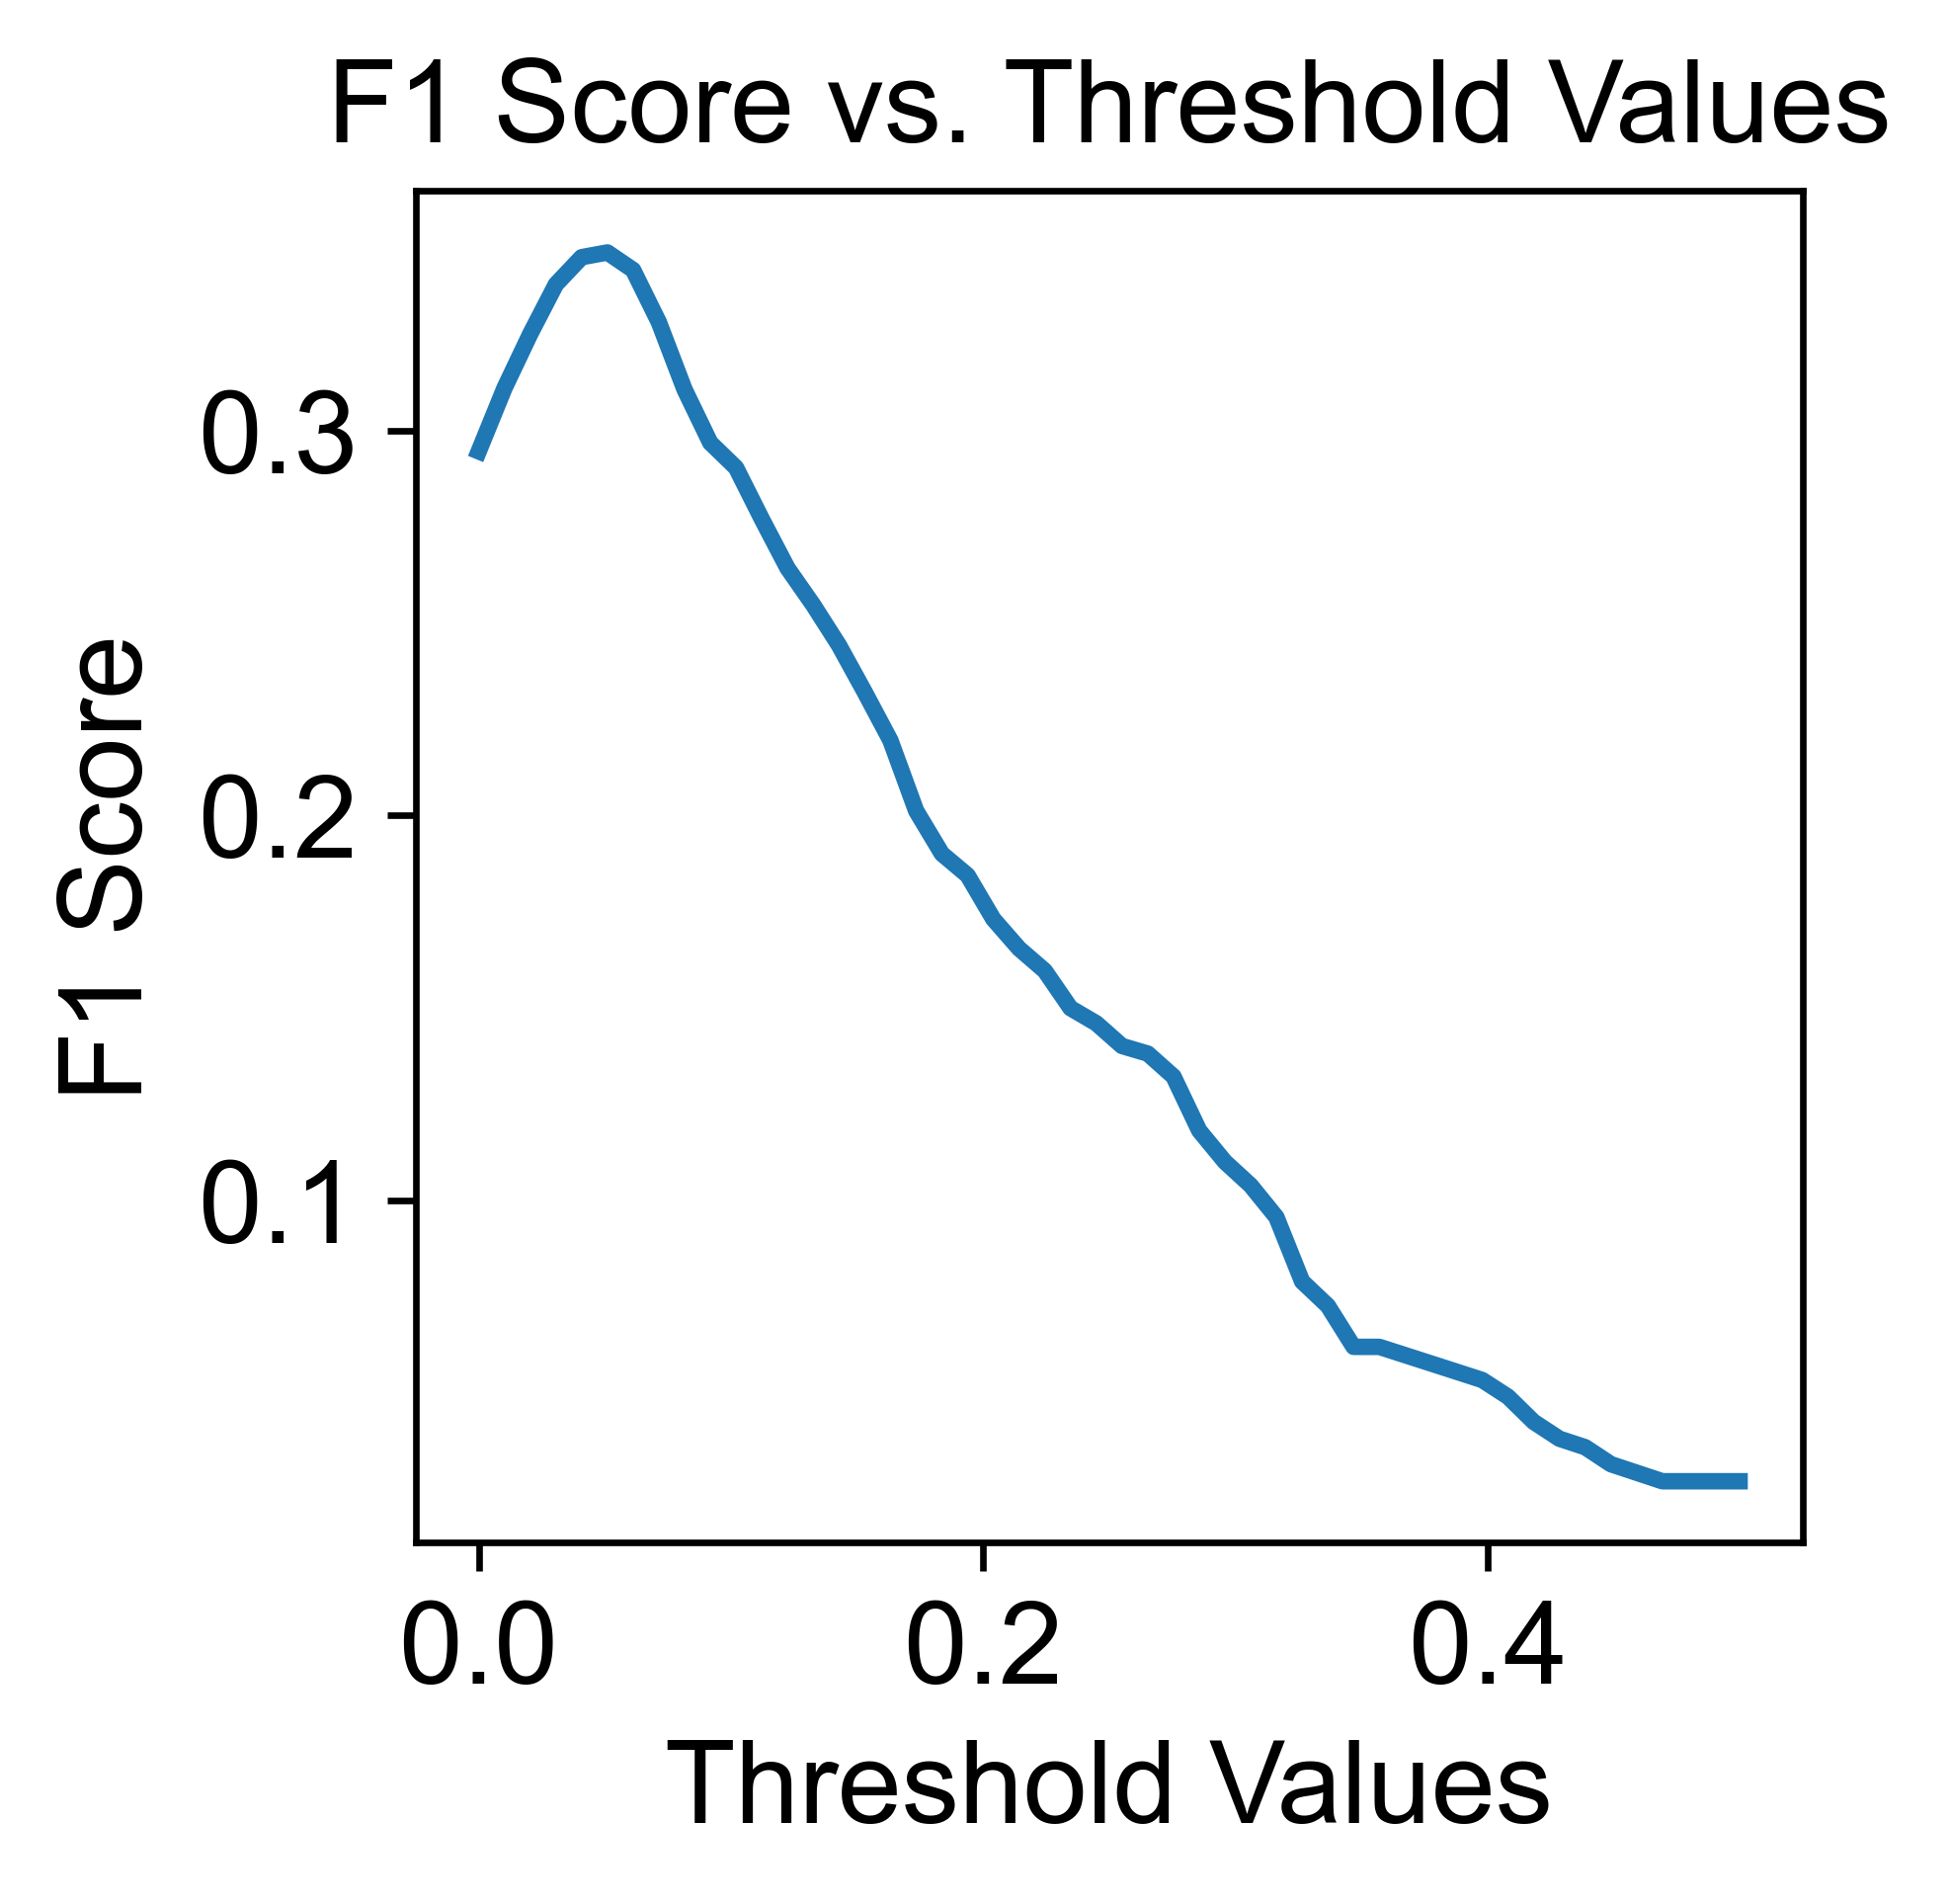

In [143]:
from sklearn.metrics import f1_score, roc_curve

# Define a range of threshold values
threshold_values = np.linspace(0.0, 0.5, 50)  # Adjust the range as needed

# Initialize lists to store F1 scores
f1_scores = []

for threshold in threshold_values:
    important_genes = avg_3_df.transpose()
    important_genes = important_genes[(important_genes > threshold).values].index.values

    important_genes_2 = avg_5_df.transpose()
    important_genes_2 = important_genes_2[(important_genes_2 > threshold).values].index.values

    important_genes_all = np.unique(np.concatenate((important_genes, important_genes_2)))

    # Getting the true labels based on the ground truth
    true_labels = [1 if each in de_genes_df.values.reshape(-1) else 0 for each in all_genes]
    pred_labels = [1 if each in important_genes_all else 0 for each in all_genes]

    f1 = f1_score(true_labels, pred_labels)
    f1_scores.append(f1)

# Create a line plot
plt.figure()
plt.plot(threshold_values, f1_scores, lw=2)
plt.xlabel('Threshold Values')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold Values')
plt.grid()
plt.show()

In [99]:
adata_int.obs["Group_num"]

Cell1       Group1
Cell2       Group2
Cell3       Group1
Cell4       Group1
Cell5       Group1
             ...  
Cell7995    Group1
Cell7997    Group1
Cell7998    Group1
Cell7999    Group1
Cell8000    Group2
Name: Group_num, Length: 7868, dtype: category
Categories (2, object): ['Group1', 'Group2']

In [100]:
adata_int.obs["Group"]

Cell1       0
Cell2       1
Cell3       0
Cell4       0
Cell5       0
           ..
Cell7995    0
Cell7997    0
Cell7998    0
Cell7999    0
Cell8000    1
Name: Group, Length: 7868, dtype: int64

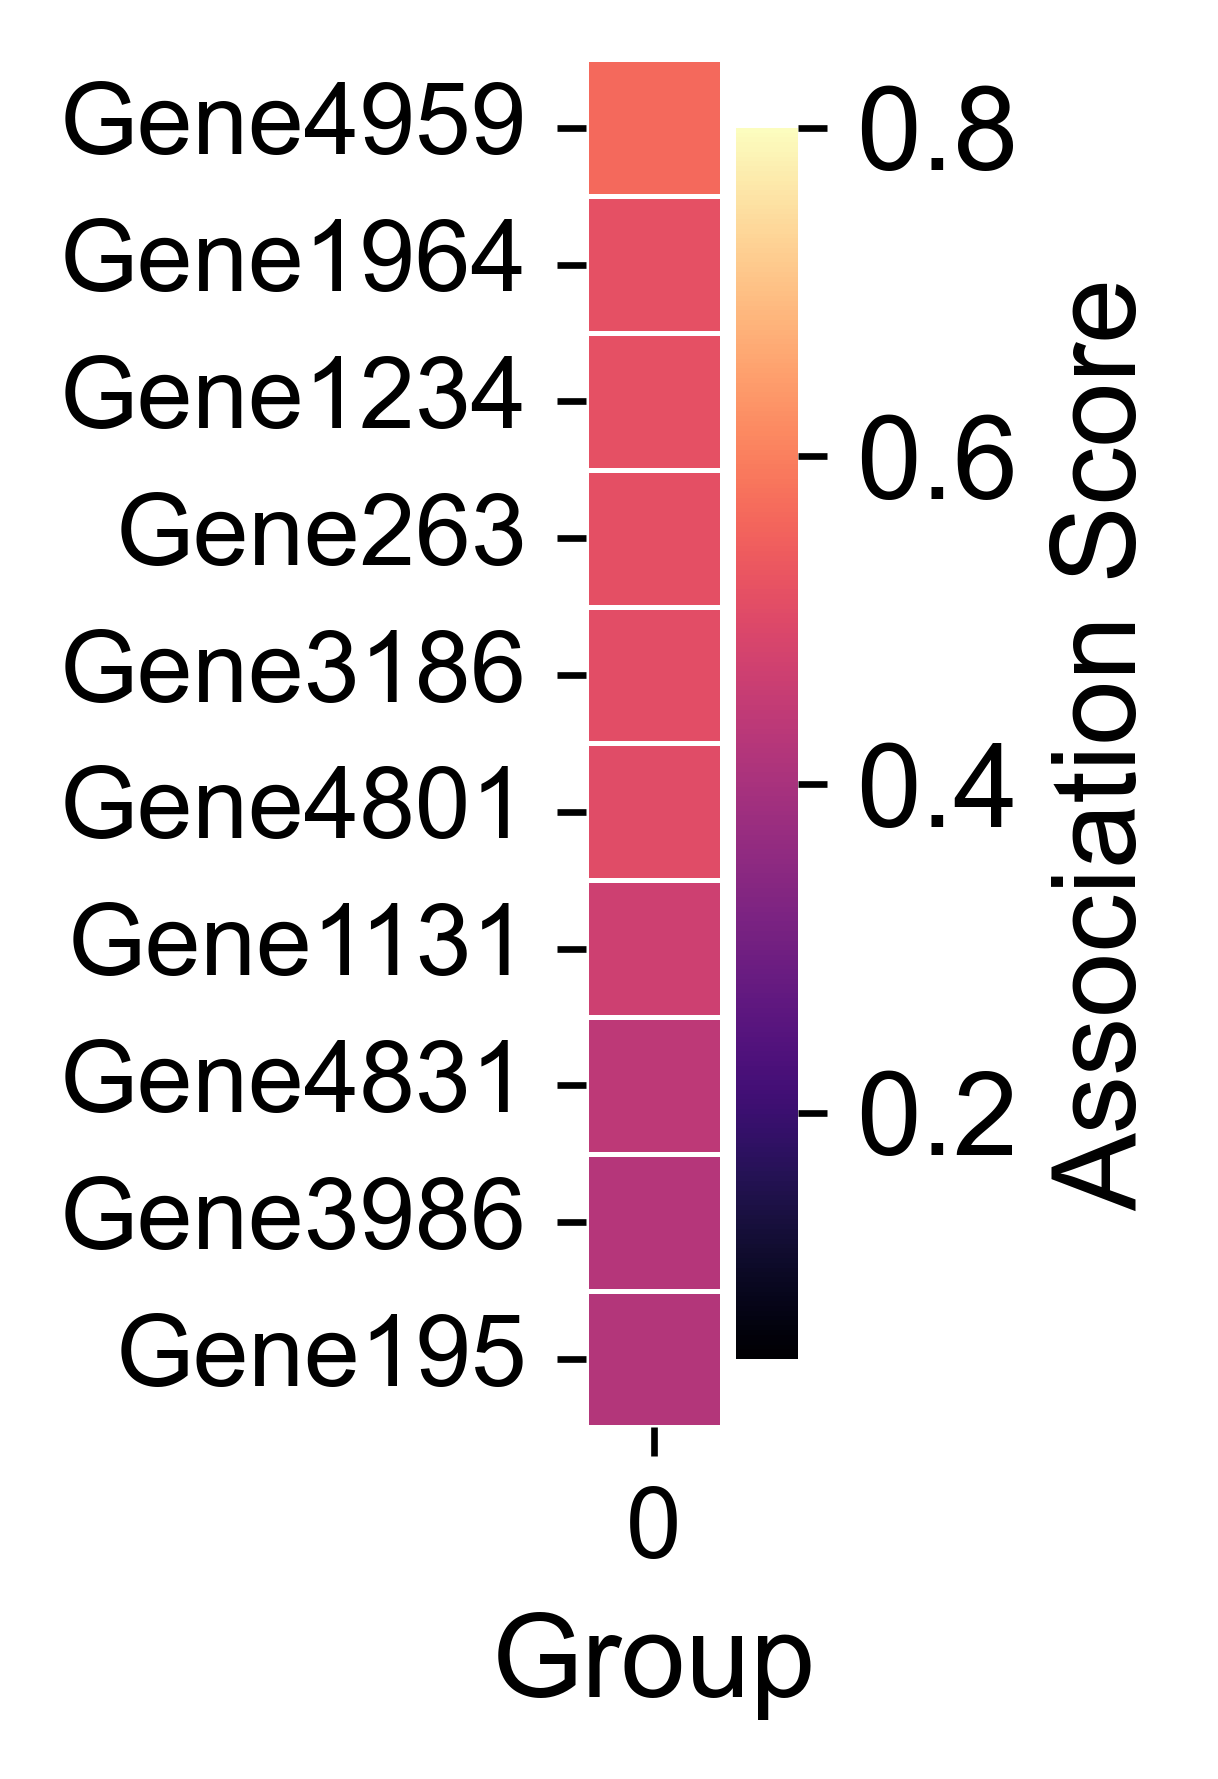

In [101]:
setup_seed(8)

plot_3_df = avg_3_df[top_100_3[:10]]
# std_scaler = StandardScaler()
 
# df_scaled = std_scaler.fit_transform(plot_3_df.values)
# df_scaled = pd.DataFrame(df_scaled, columns=plot_3_df.columns, index = plot_3_df.index)
# plt.subplots(figsize=(30,6))
g = sns.heatmap(plot_3_df.transpose(), vmin = 0.05, vmax = 0.8, cmap = "magma", xticklabels=True, square=True, yticklabels=True, cbar_kws={'label': 'Association Score', "shrink": .90, "pad": 0.01}
, cbar=True, linewidth=.4)
g.grid(False)
# g.grid(False)
g.set_aspect('equal')
# g.cax.remove()

# g = sns.clustermap(data=corr_s, annot=True, fmt='d',cmap = "Blues")
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)

# hm = g.ax_heatmap.get_position()
# col = g.ax_col_dendrogram.get_position()
# g.ax_col_dendrogram.set_position([hm.x0, hm.y0 + hm.height, hm.width, col.height * 0.7])
# row = g.ax_row_dendrogram.get_position()
# g.ax_row_dendrogram.set_position([hm.x0 - row.width * 0.7, hm.y0, row.width * 0.7, hm.height])

# plt.title("3'")
plt.show()


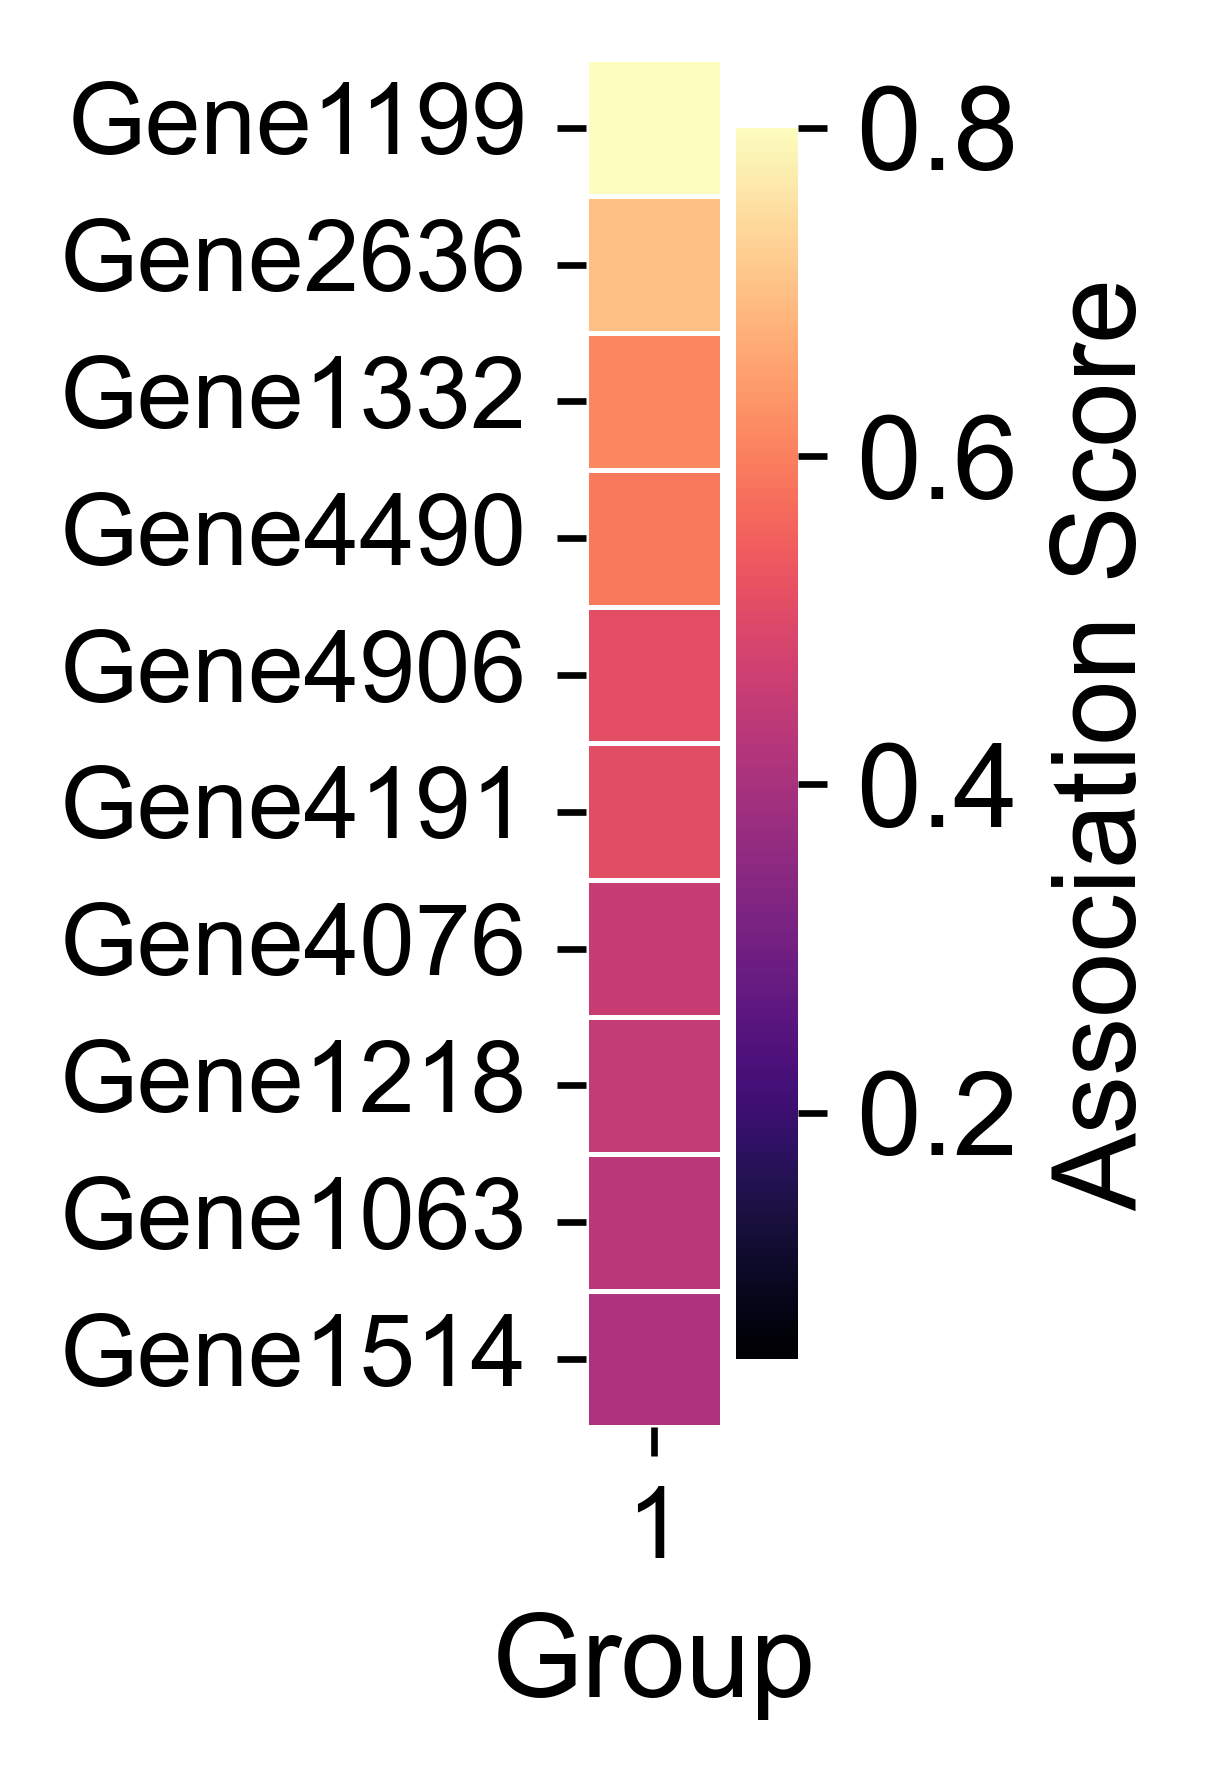

In [102]:
setup_seed(8)

plot_5_df = avg_5_df[top_100_5[:10]]
# std_scaler = StandardScaler()
 
# df_scaled = std_scaler.fit_transform(plot_3_df.values)
# df_scaled = pd.DataFrame(df_scaled, columns=plot_3_df.columns, index = plot_3_df.index)
# plt.subplots(figsize=(30,6))
g = sns.heatmap(plot_5_df.transpose(), vmin = 0.05, vmax = 0.8, cmap = "magma", xticklabels=True, square=True, yticklabels=True, cbar_kws={'label': 'Association Score', "shrink": .90, "pad": 0.01}
, cbar=True, linewidth=.4)
g.grid(False)
# g.grid(False)
g.set_aspect('equal')
# g.cax.remove()

# g = sns.clustermap(data=corr_s, annot=True, fmt='d',cmap = "Blues")
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)

# hm = g.ax_heatmap.get_position()
# col = g.ax_col_dendrogram.get_position()
# g.ax_col_dendrogram.set_position([hm.x0, hm.y0 + hm.height, hm.width, col.height * 0.7])
# row = g.ax_row_dendrogram.get_position()
# g.ax_row_dendrogram.set_position([hm.x0 - row.width * 0.7, hm.y0, row.width * 0.7, hm.height])

# plt.title("3'")
plt.show()

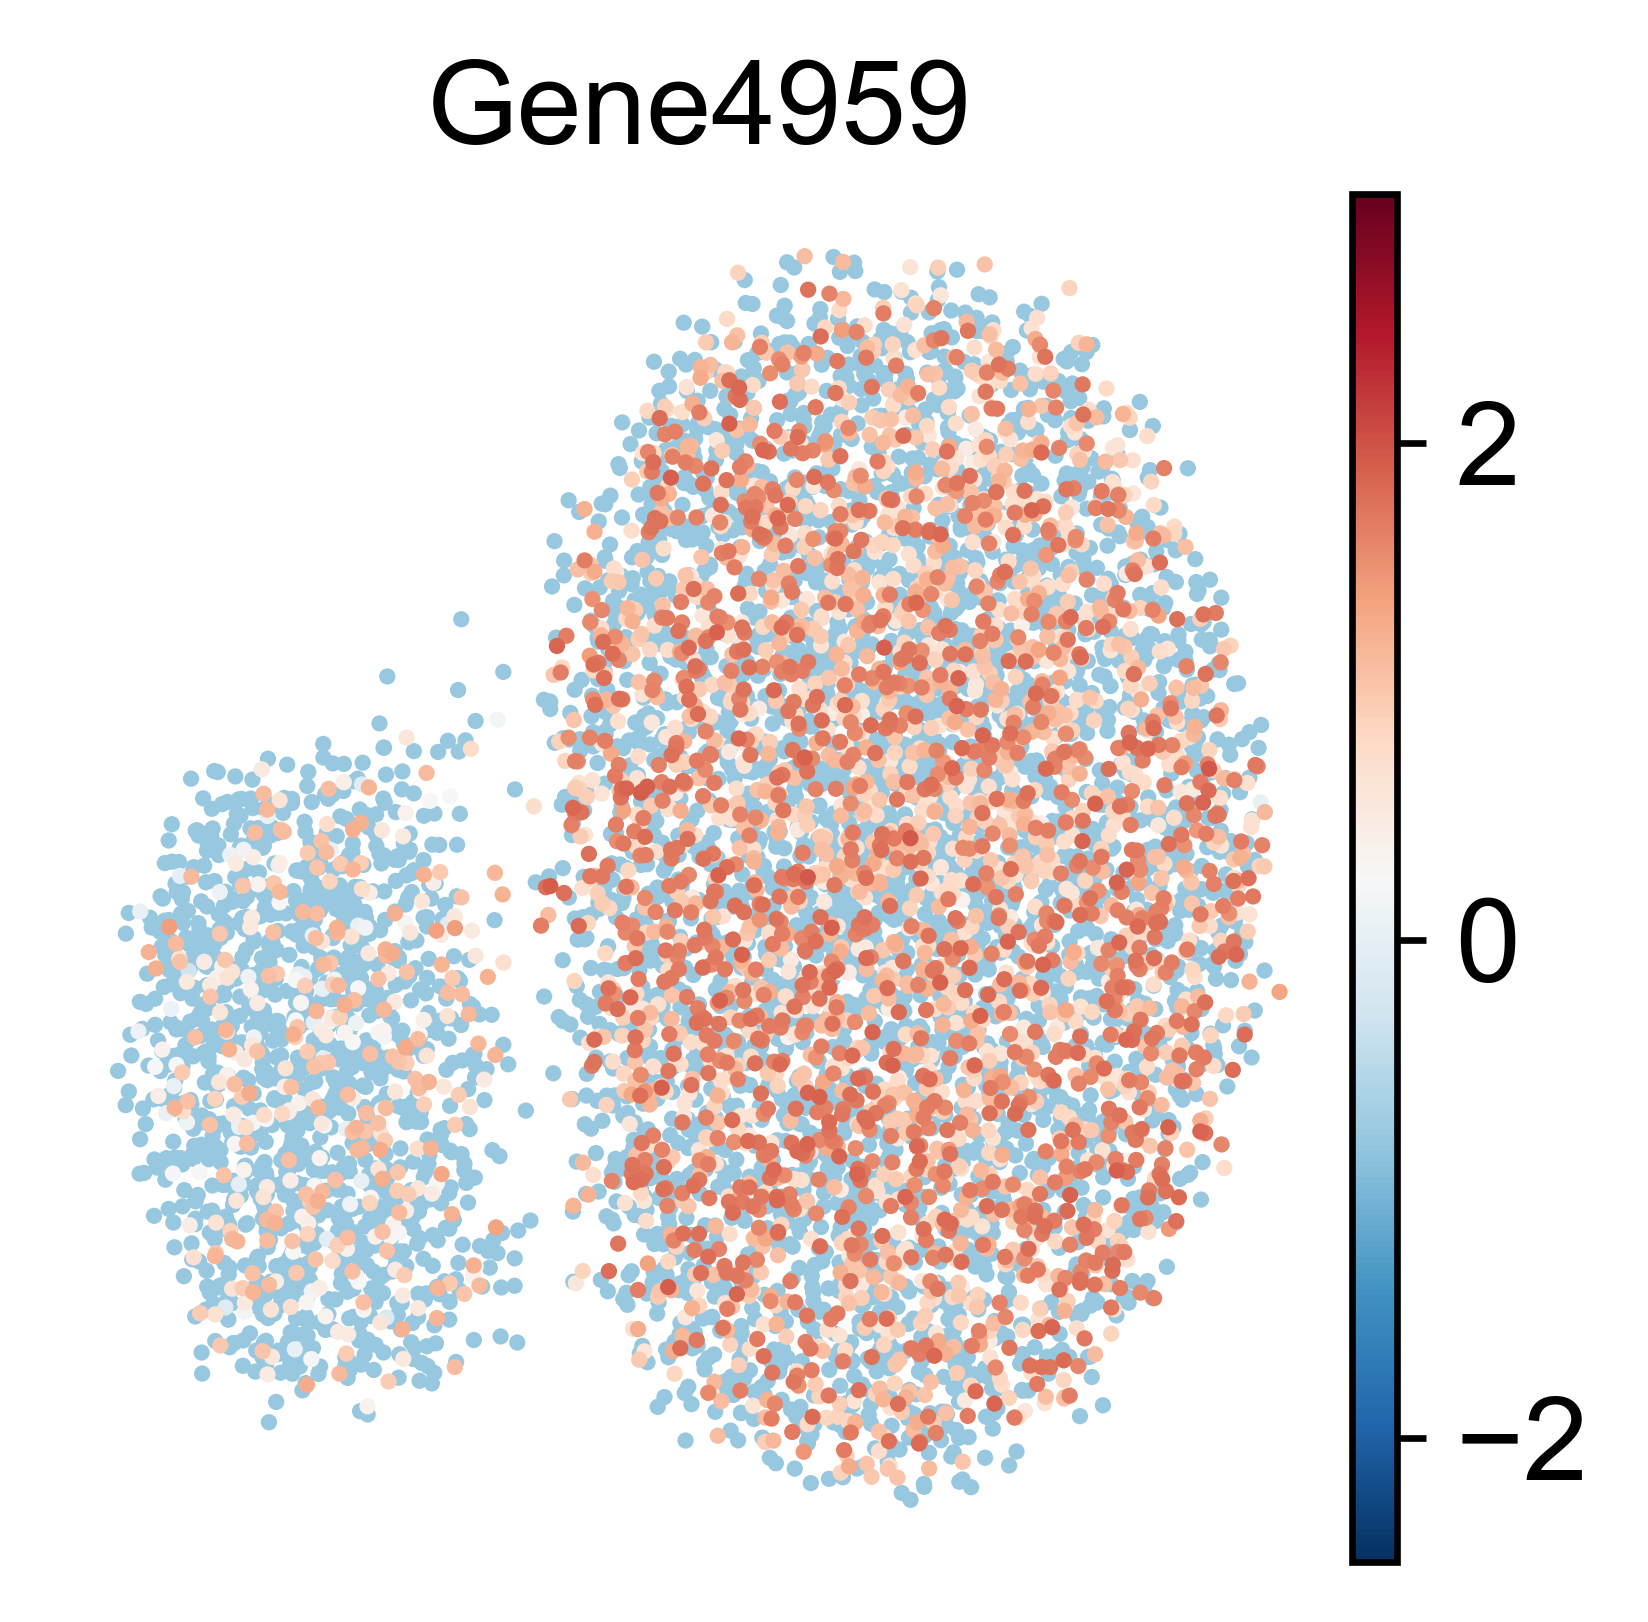

In [111]:
sc.pl.umap(adata_int, color = "Gene4959", layer = "X_raw_scaled", color_map = "RdBu_r", vmax = 3, vmin = -2.5)

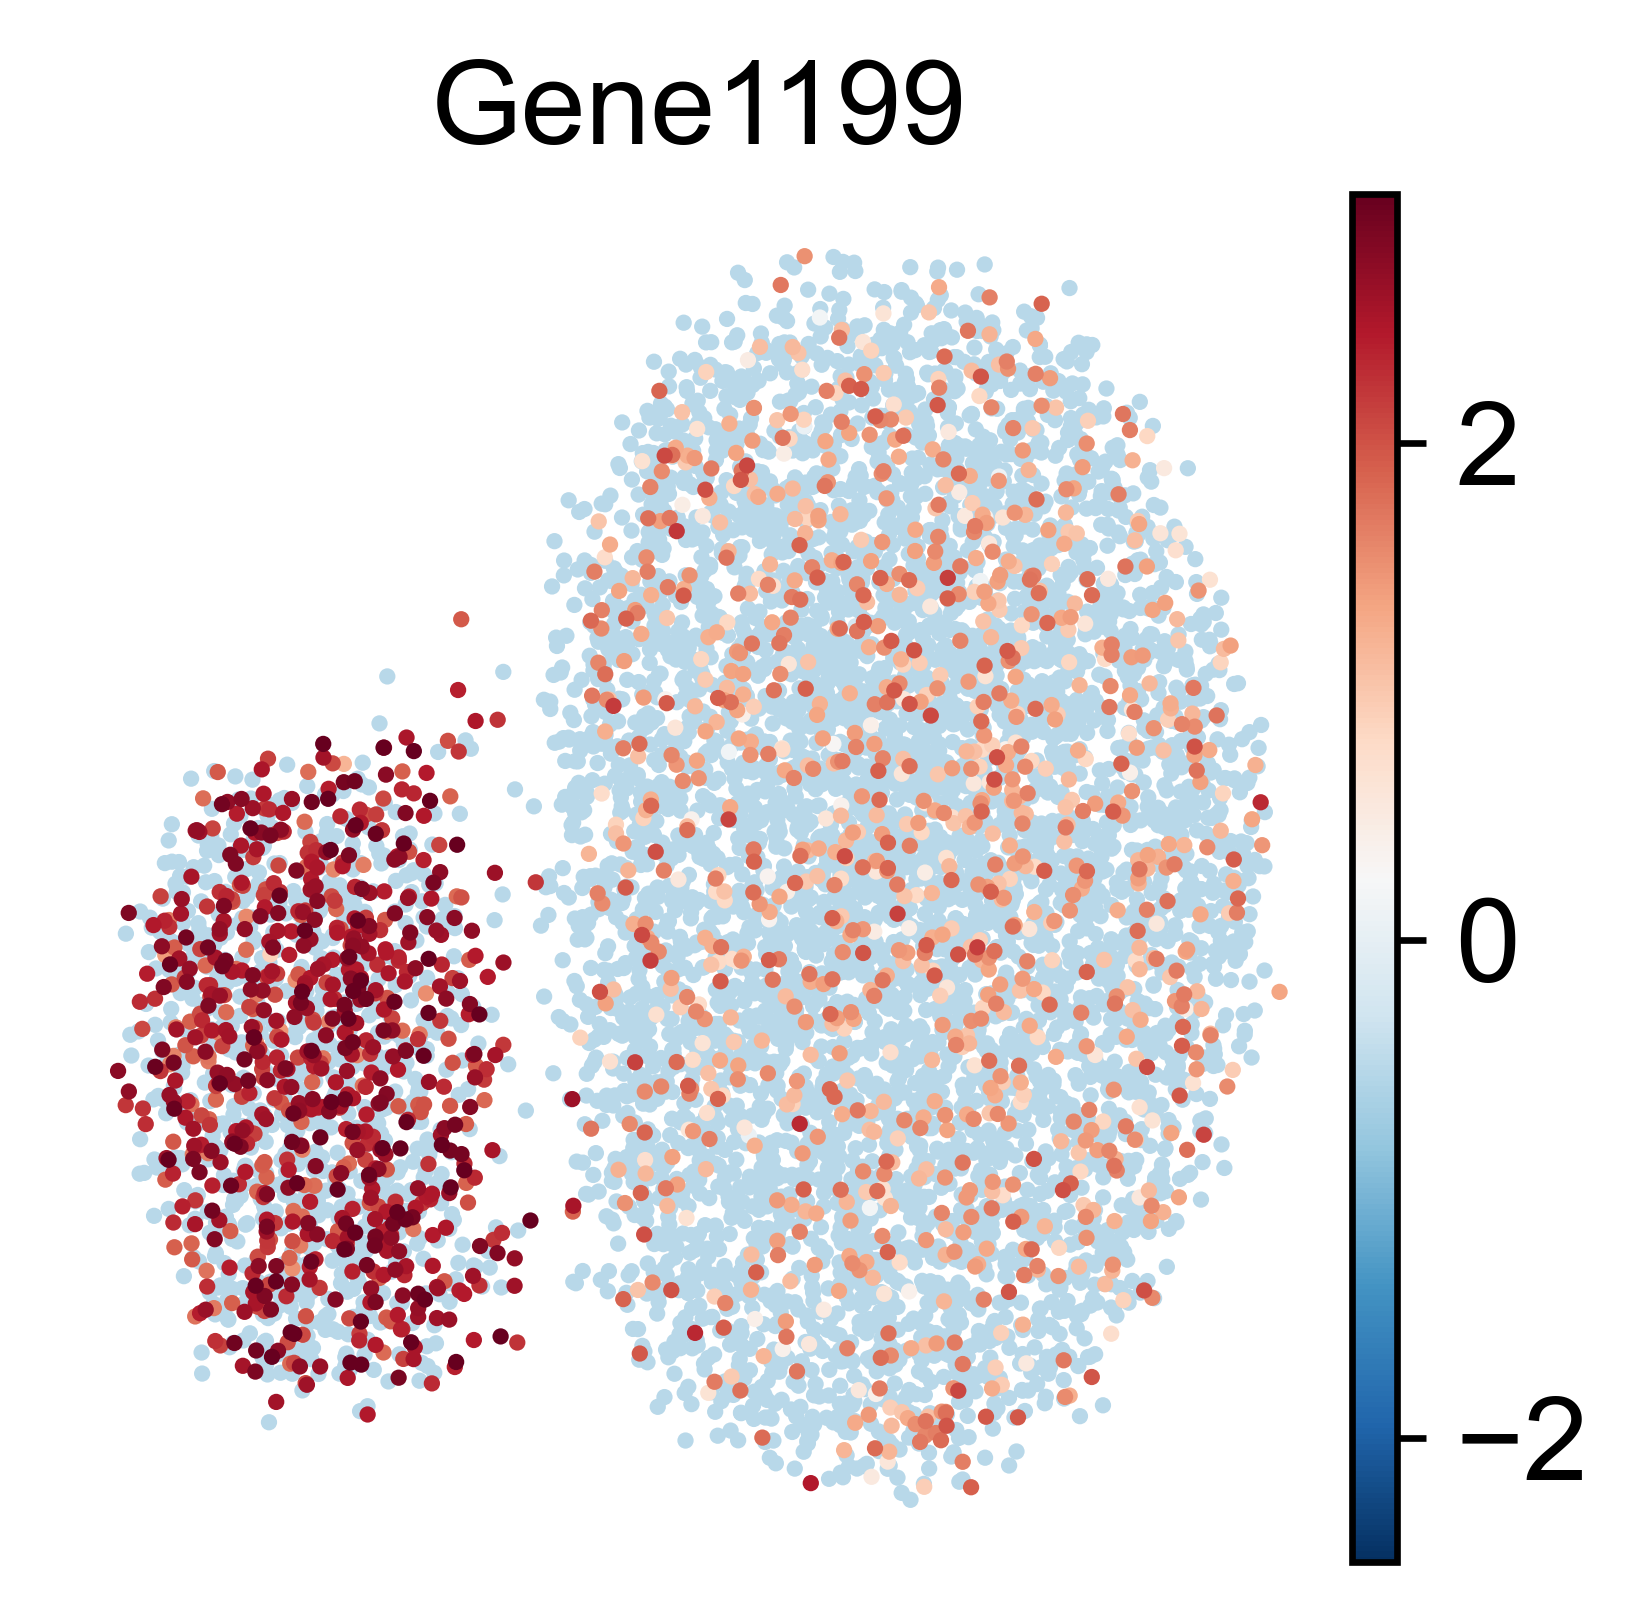

In [112]:
sc.pl.umap(adata_int, color = "Gene1199", layer = "X_raw_scaled", color_map = "RdBu_r", vmax = 3, vmin = -2.5)

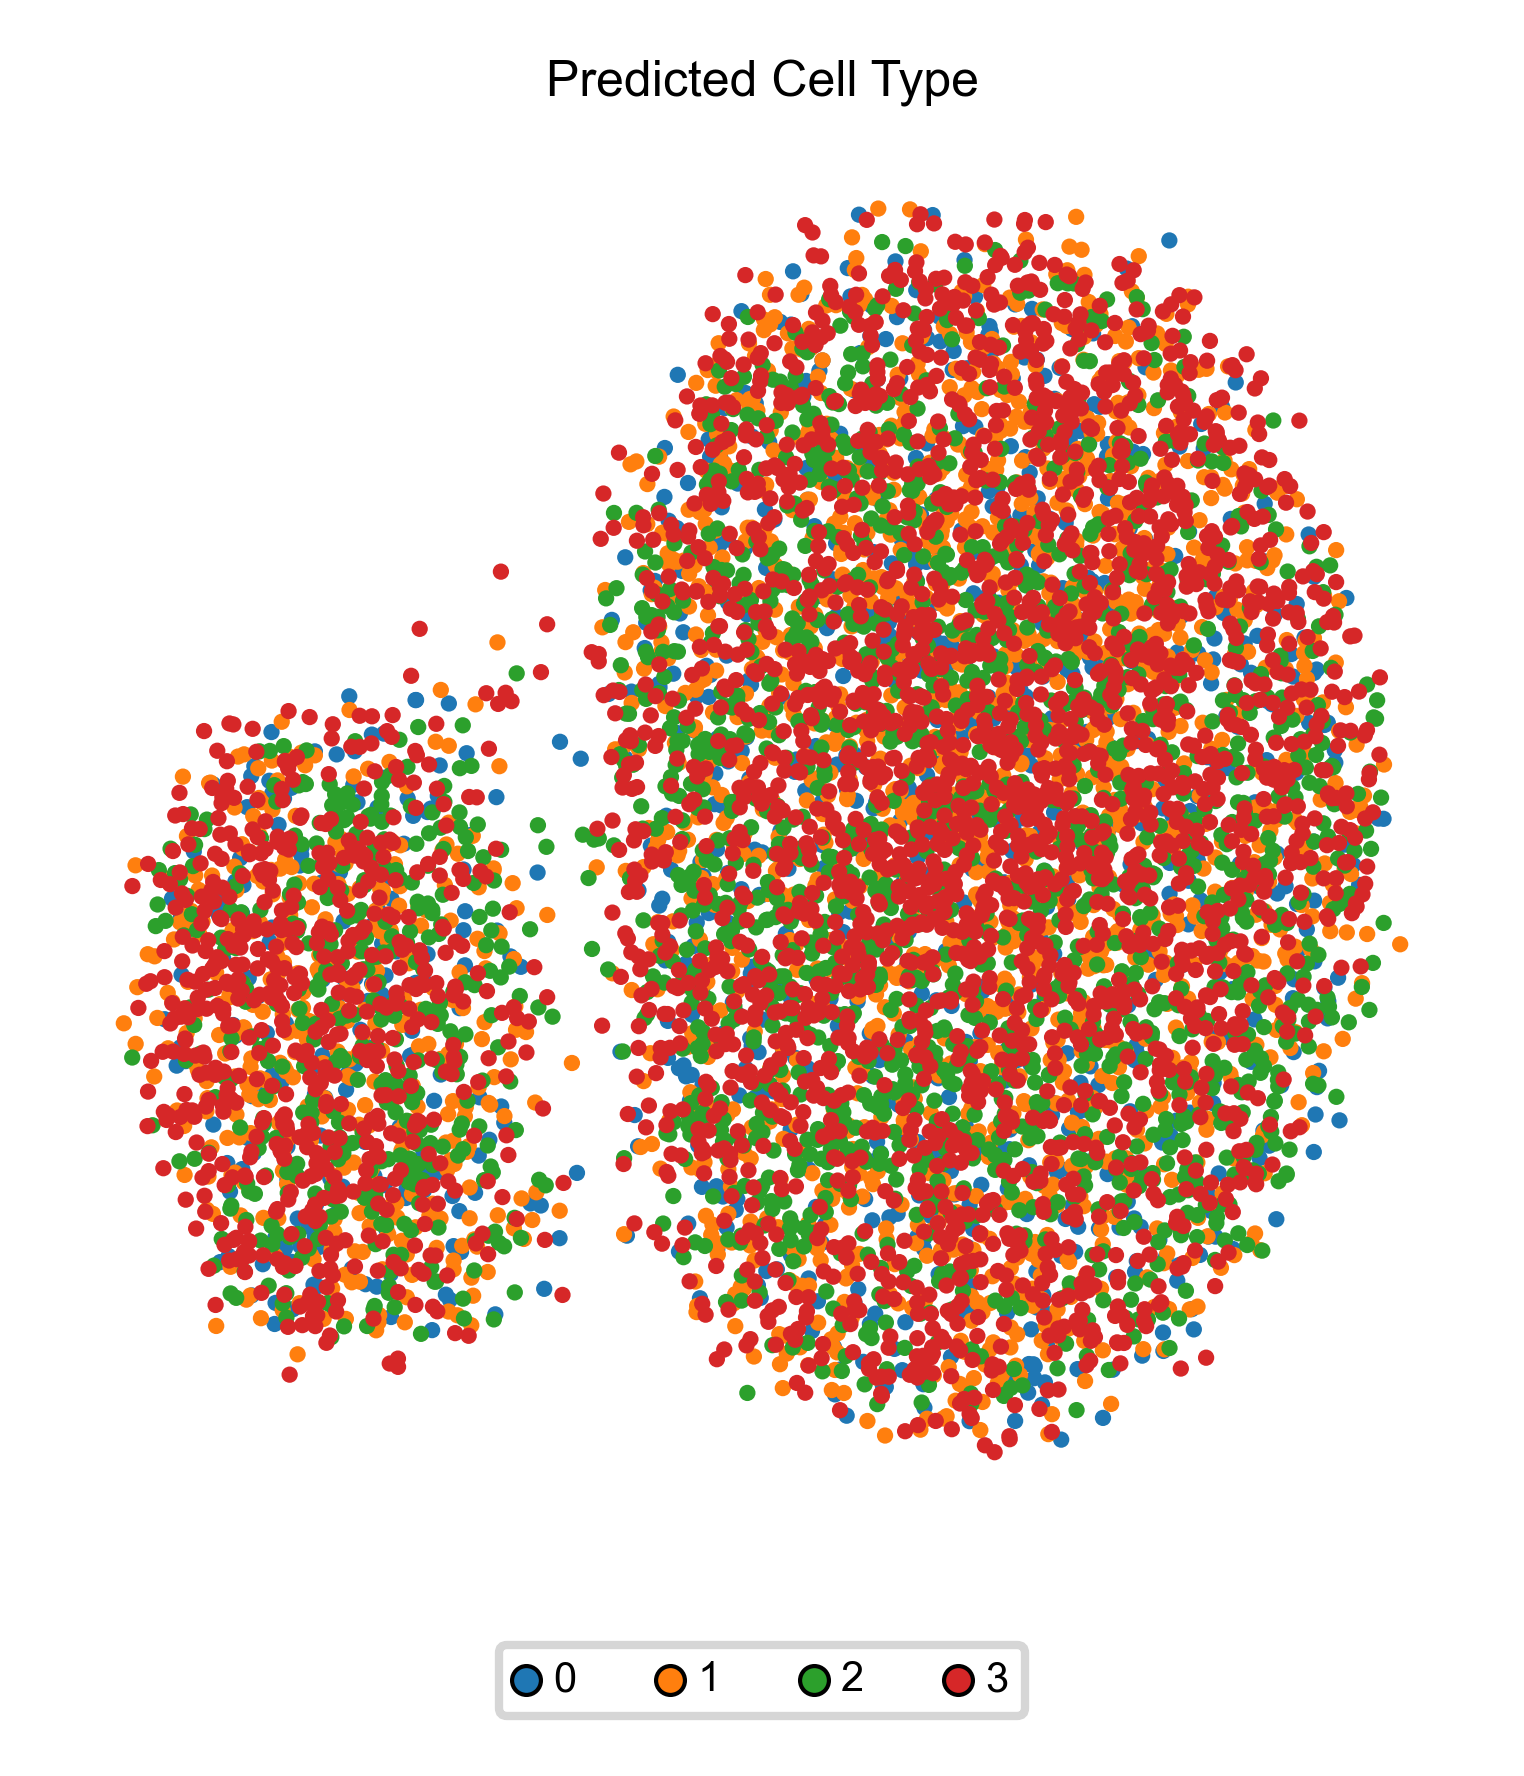

In [106]:
# Define the colorcet paletteasdasd
custom_palette = cc.glasbey_category10

ax = sc.pl.umap(adata_int, color='Batch_num', palette=custom_palette,
           frameon=False, legend_fontsize=3.5, show=False)

# Set the plot title with the desired font size
ax.set_title('Predicted Cell Type', fontsize=6)

# Adjust the legend font size
handles, labels = plt.gca().get_legend_handles_labels()

# Adjust the size of the circles
for handle in handles:
    handle.set_sizes([12])
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

# Move the legend to the right side of the plot
plt.legend(handles=handles, labels=labels, prop={'size': 5}, ncol = 4, 
           loc='upper center', bbox_to_anchor=(0.5, -0.08))

# Show the plot
plt.show()

## Venn Diagram

In [151]:
adata_int = sc.read("genex_simulation_1_temp.h5ad")

# uncomment this for our model.
if "X_raw" not in adata_int.layers:
    adata = sc.read_h5ad('genex_simulation_1.h5ad')
    
    # subset to only two cell types that has subtle different which are acinar and ductal cell type
#     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
    adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
    adata_int.uns = adata.uns
    
adata_int.layers["X_raw_scaled"] = sc.pp.scale(adata_int.layers["X_raw"].copy(), copy = True)
adata_int.layers["X_corrected_scaled"] = sc.pp.scale(adata_int.obsm["X_latent"].copy(), copy = True)

In [152]:
adata_int.layers["X_corrected"] = adata_int.obsm["X_latent"]

In [153]:
def compute_logfc(cell_adata, group, group_name, layer):
#     cell_adata = deg_adata[deg_adata.obs["CellType"] == cell_type_name]
    group_list = sorted(list(set(cell_adata.obs[group_name])))
    
    pseudocount = 1

    group_A = cell_adata[cell_adata.obs[group_name] == group] #BMA
    group_A_log = np.log2(np.mean(np.expm1(group_A.layers[layer].toarray()), axis = 0) + pseudocount)
    
    list_logfc = []
    
    for each in group_list:
        if each != group:
            group_B = cell_adata[cell_adata.obs[group_name] == each] #LLN
            group_B_log = np.log2(np.mean(np.expm1(group_B.layers[layer].toarray()), axis = 0) + pseudocount)

    #         logfc = pd.DataFrame(np.around(group_A_log - group_B_log, 4), index = cell_adata.var.index, columns = ["logfc"])
            logfc = np.around(group_A_log - group_B_log, 4)
            list_logfc.append(logfc)
    if len(list_logfc) == 1:
        return pd.DataFrame(list_logfc[0], index = cell_adata.var.index, columns = ["logfc"])
    else:
        return pd.DataFrame(np.mean(list_logfc, axis = 1), index = cell_adata.var.index, columns = ["logfc"])

In [154]:
group_name = "Group_num"
groups = sorted(list(set(adata_int.obs[group_name])))
# groups = sorted(list(set(adata_int.obs["Group"])))

groups

['Group1', 'Group2']

In [155]:
# adata_int.uns['log1p'] = None
adata_int.uns['log1p']['base'] = None

In [156]:
# uncomment for raw data degs
# adata_int.obsm["X_raw_pca"] = sc.pp.pca(adata_int.layers["X_raw"], copy = True)
# sc.tl.dendrogram(adata_int, use_rep = "X_raw_pca", groupby = "Group_num", optimal_ordering=False)

layer_name = "X_corrected"

sc.tl.dendrogram(adata_int, use_rep = "X_pca", groupby = group_name, optimal_ordering=False)
sc.tl.rank_genes_groups(adata_int, group_name, method='wilcoxon', use_raw = False, corr_method='bonferroni', layer = layer_name, pts = True)
adata_int.X = adata_int.layers[layer_name]
sc.tl.filter_rank_genes_groups(adata_int, min_in_group_fraction=0.25, key = "rank_genes_groups",
                               max_out_group_fraction = 1.01,
                               min_fold_change=0.0)


raw_deg = sc.get.rank_genes_groups_df(adata_int, group = groups[0], pval_cutoff=0.05, key='rank_genes_groups_filtered')["names"]

deg_fc = compute_logfc(adata_int, groups[0], group_name, layer_name)
    
## get only the significance genes
boolean_pvalue = []

for gene in deg_fc.index:
    if gene in list(raw_deg):
        boolean_pvalue.append(True)
    else:
        boolean_pvalue.append(False)

deg_fc["pvalue"] = boolean_pvalue

# filtering for the log fold change and the pvalue
filtered = (deg_fc["pvalue"] == True) & ((deg_fc["logfc"] > 0.0) | (deg_fc["logfc"] < -0.0))

# for scVI and Scanorama as they have normalised their data, we only take the p-value
# filtered = (deg_fc["pvalue"] == True)

deg_fc_filtered = deg_fc[filtered]

#     deg_set = deg_set[~pd.isnull(deg_set)][:10]

#     deg_set = np.array(deg_set)

# deg_gene = deg_fc_filtered.sort_values(by="logfc", ascending = False).index.values

raw_deg = deg_fc_filtered.index.values

print(len(raw_deg))

454


In [157]:
corrected_deg = raw_deg

In [158]:
# uncomment for raw data degs
adata_int.obsm["X_raw_pca"] = sc.pp.pca(adata_int.layers["X_raw"], copy = True)
# sc.tl.dendrogram(adata_int, use_rep = "X_raw_pca", groupby = "Group_num", optimal_ordering=False)

layer_name = "X_raw"

sc.tl.dendrogram(adata_int, use_rep = "X_raw_pca", groupby = group_name, optimal_ordering=False)
sc.tl.rank_genes_groups(adata_int, group_name, method='wilcoxon', use_raw = False, corr_method='bonferroni', layer = layer_name, pts = True)
adata_int.X = adata_int.layers[layer_name]
sc.tl.filter_rank_genes_groups(adata_int, min_in_group_fraction=0.25, key = "rank_genes_groups",
                               max_out_group_fraction = 1.01,
                               min_fold_change=0.0)


raw_deg = sc.get.rank_genes_groups_df(adata_int, group = groups[0], pval_cutoff=0.05, key='rank_genes_groups_filtered')["names"]

deg_fc = compute_logfc(adata_int, groups[0], group_name, layer_name)
    
## get only the significance genes
boolean_pvalue = []

for gene in deg_fc.index:
    if gene in list(raw_deg):
        boolean_pvalue.append(True)
    else:
        boolean_pvalue.append(False)

deg_fc["pvalue"] = boolean_pvalue

# filtering for the log fold change and the pvalue
filtered = (deg_fc["pvalue"] == True) & ((deg_fc["logfc"] > 0.0) | (deg_fc["logfc"] < 0.0))

# for scVI and Scanorama as they have normalised their data, we only take the p-value
# filtered = (deg_fc["pvalue"] == True)

deg_fc_filtered = deg_fc[filtered]

#     deg_set = deg_set[~pd.isnull(deg_set)][:10]

#     deg_set = np.array(deg_set)

# deg_gene = deg_fc_filtered.sort_values(by="logfc", ascending = False).index.values

raw_deg = deg_fc_filtered.index.values

print(len(raw_deg))

27


In [159]:
# defining the threshold
threshold_values = 0.05

important_genes = avg_3_df.transpose()
important_genes = important_genes[(important_genes > threshold_values).values].index.values

important_genes_2 = avg_5_df.transpose()
important_genes_2 = important_genes_2[(important_genes_2 > threshold_values).values].index.values

important_genes_all = np.unique(np.concatenate((important_genes, important_genes_2)))

print(len(important_genes_all))

353


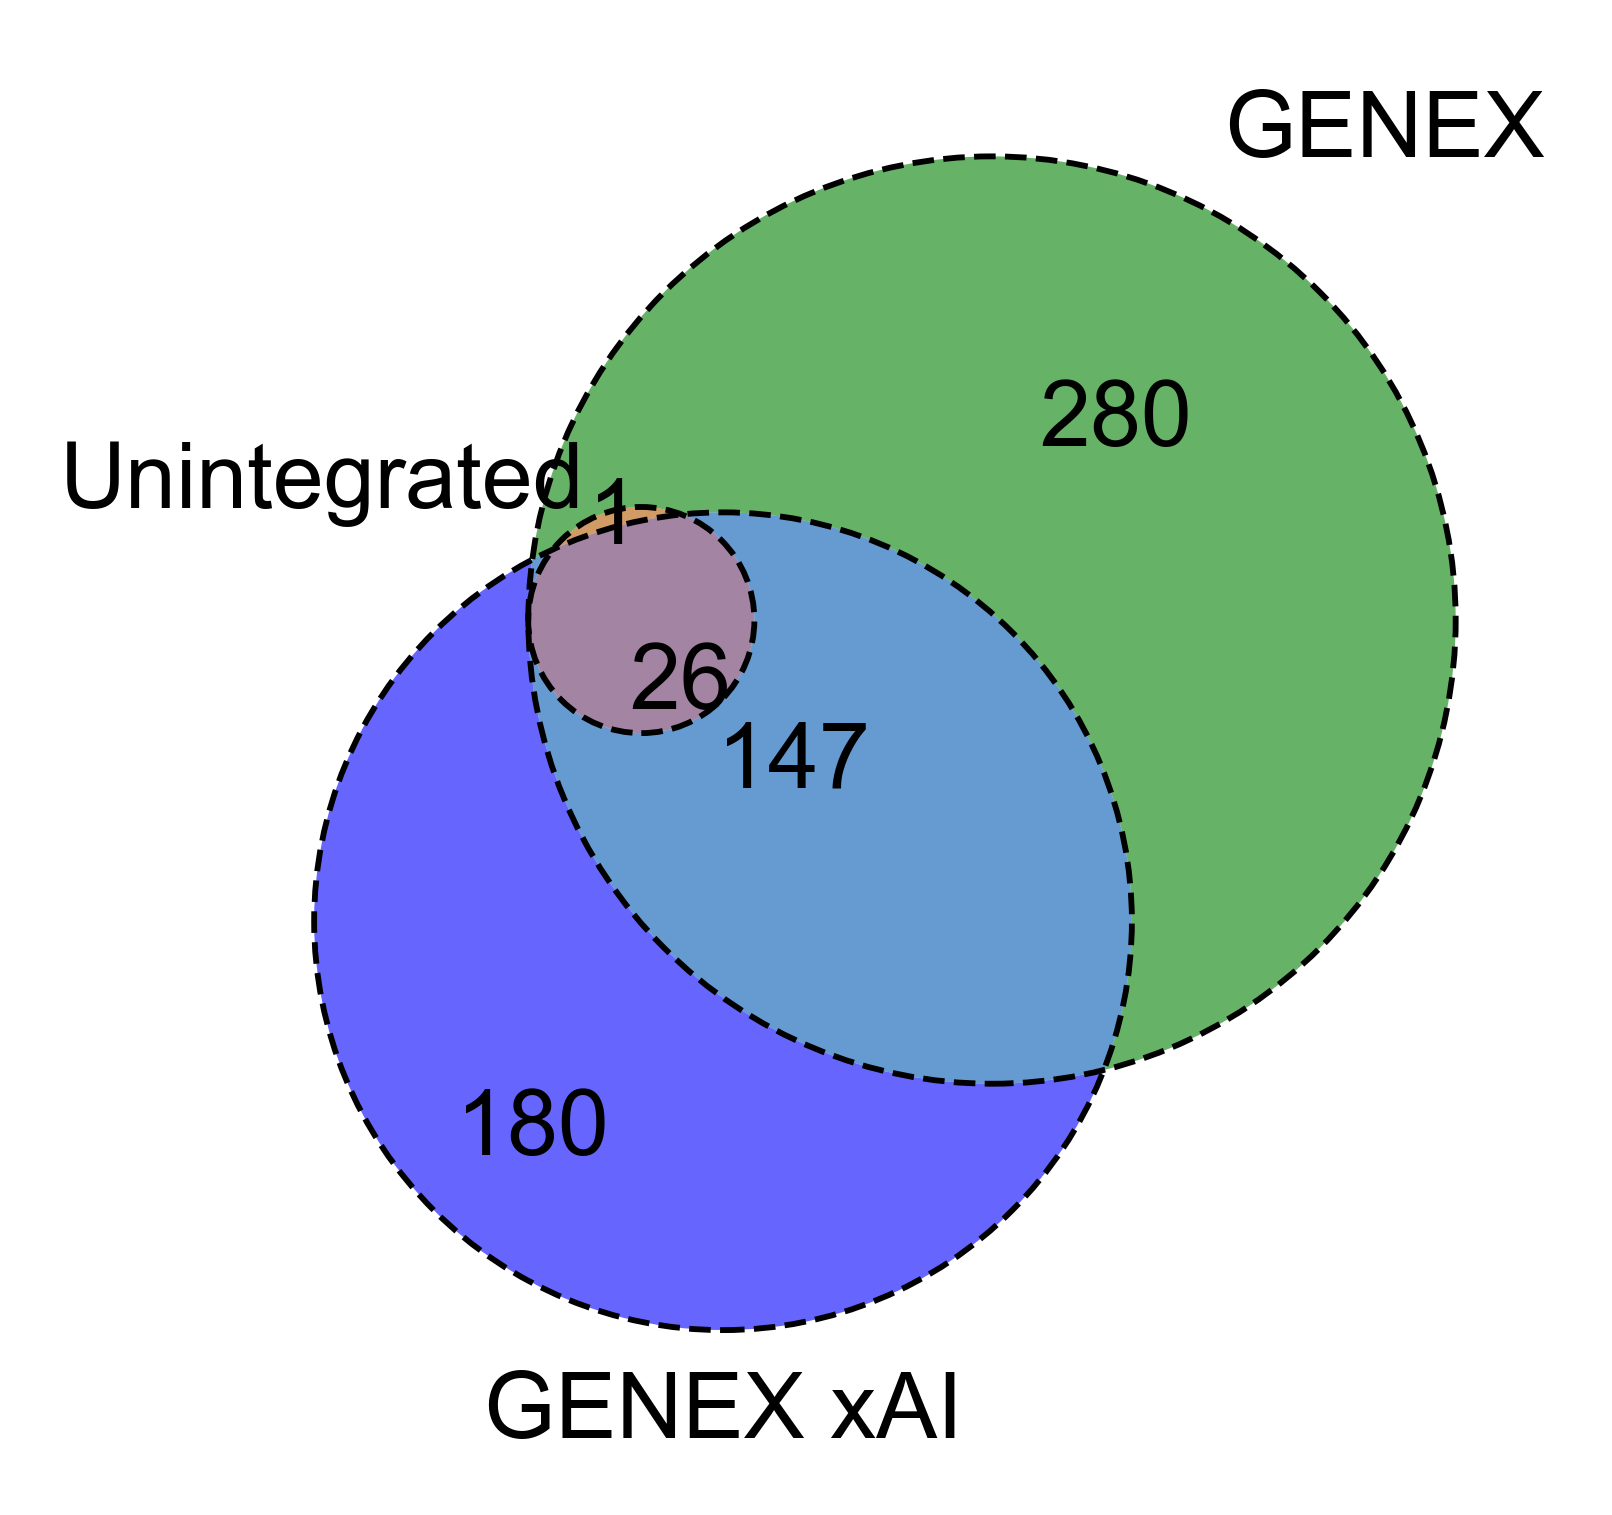

In [268]:

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# Example sets
set1 = set(raw_deg)
set2 = set(corrected_deg)
set3 = set(important_genes_all)

# Create a Venn diagram
out = venn3([set1, set2, set3], ('Unintegrated', 'GENEX', 'GENEX xAI'), alpha = 0.6)
venn3_circles(subsets=([set1, set2, set3]), linestyle = "dashed", linewidth= 0.7)  

for text in out.set_labels:
    text.set_fontsize(11)
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(11)

# for text in venn.set_labels:
#     text.set_fontsize(8)  # Adjust the font size as needed
plt.savefig('plot/simul_venn_diagram.svg', format='svg', dpi=300)
plt.show()

In [221]:
# Get the unique elements in Set 3 that are not in Set 1 or Set 2
unique_set3 = set3 - (set1 | set2)

# Display the result
print(unique_set3)

{'Gene4002', 'Gene1532', 'Gene2363', 'Gene782', 'Gene4498', 'Gene209', 'Gene4166', 'Gene1514', 'Gene213', 'Gene4367', 'Gene3546', 'Gene4906', 'Gene1063', 'Gene1077', 'Gene2914', 'Gene994', 'Gene3151', 'Gene3329', 'Gene3174', 'Gene1101', 'Gene79', 'Gene2094', 'Gene4251', 'Gene3206', 'Gene2481', 'Gene647', 'Gene2757', 'Gene1054', 'Gene2537', 'Gene3949', 'Gene4798', 'Gene2721', 'Gene1600', 'Gene1876', 'Gene2238', 'Gene3311', 'Gene2358', 'Gene302', 'Gene4546', 'Gene2222', 'Gene580', 'Gene1620', 'Gene1283', 'Gene1371', 'Gene3222', 'Gene2699', 'Gene2086', 'Gene1332', 'Gene3087', 'Gene1999', 'Gene3251', 'Gene4617', 'Gene2774', 'Gene2573', 'Gene3218', 'Gene1270', 'Gene2915', 'Gene3886', 'Gene1223', 'Gene795', 'Gene384', 'Gene2644', 'Gene4076', 'Gene4279', 'Gene4336', 'Gene121', 'Gene2415', 'Gene4869', 'Gene186', 'Gene1271', 'Gene3637', 'Gene3320', 'Gene2376', 'Gene1757', 'Gene1677', 'Gene3632', 'Gene1480', 'Gene835', 'Gene1254', 'Gene4522', 'Gene3303', 'Gene2050', 'Gene3612', 'Gene4205', 'Gene

In [234]:
uniq_gene_xai = []

for each in top_100_5:
    if each in unique_set3:
#         print(each)
        uniq_gene_xai.append(each)

Gene1199
Gene2636
Gene1332
Gene4490
Gene4906
Gene4191
Gene4076
Gene1218
Gene1063
Gene1514
Gene3612
Gene2774
Gene4166
Gene1156
Gene3971
Gene3311
Gene3805
Gene1456
Gene1283
Gene1355
Gene2222
Gene859
Gene994
Gene2992
Gene3151
Gene2374
Gene1777
Gene302
Gene2936
Gene4163
Gene1270
Gene1742
Gene1667
Gene2238
Gene2521
Gene1543
Gene2834
Gene3073
Gene1532
Gene411
Gene3726
Gene3222
Gene911
Gene3174
Gene2094
Gene3157
Gene4169
Gene4945
Gene3718
Gene3637


In [295]:
# uniq_gene_xai

<Figure size 900x900 with 0 Axes>

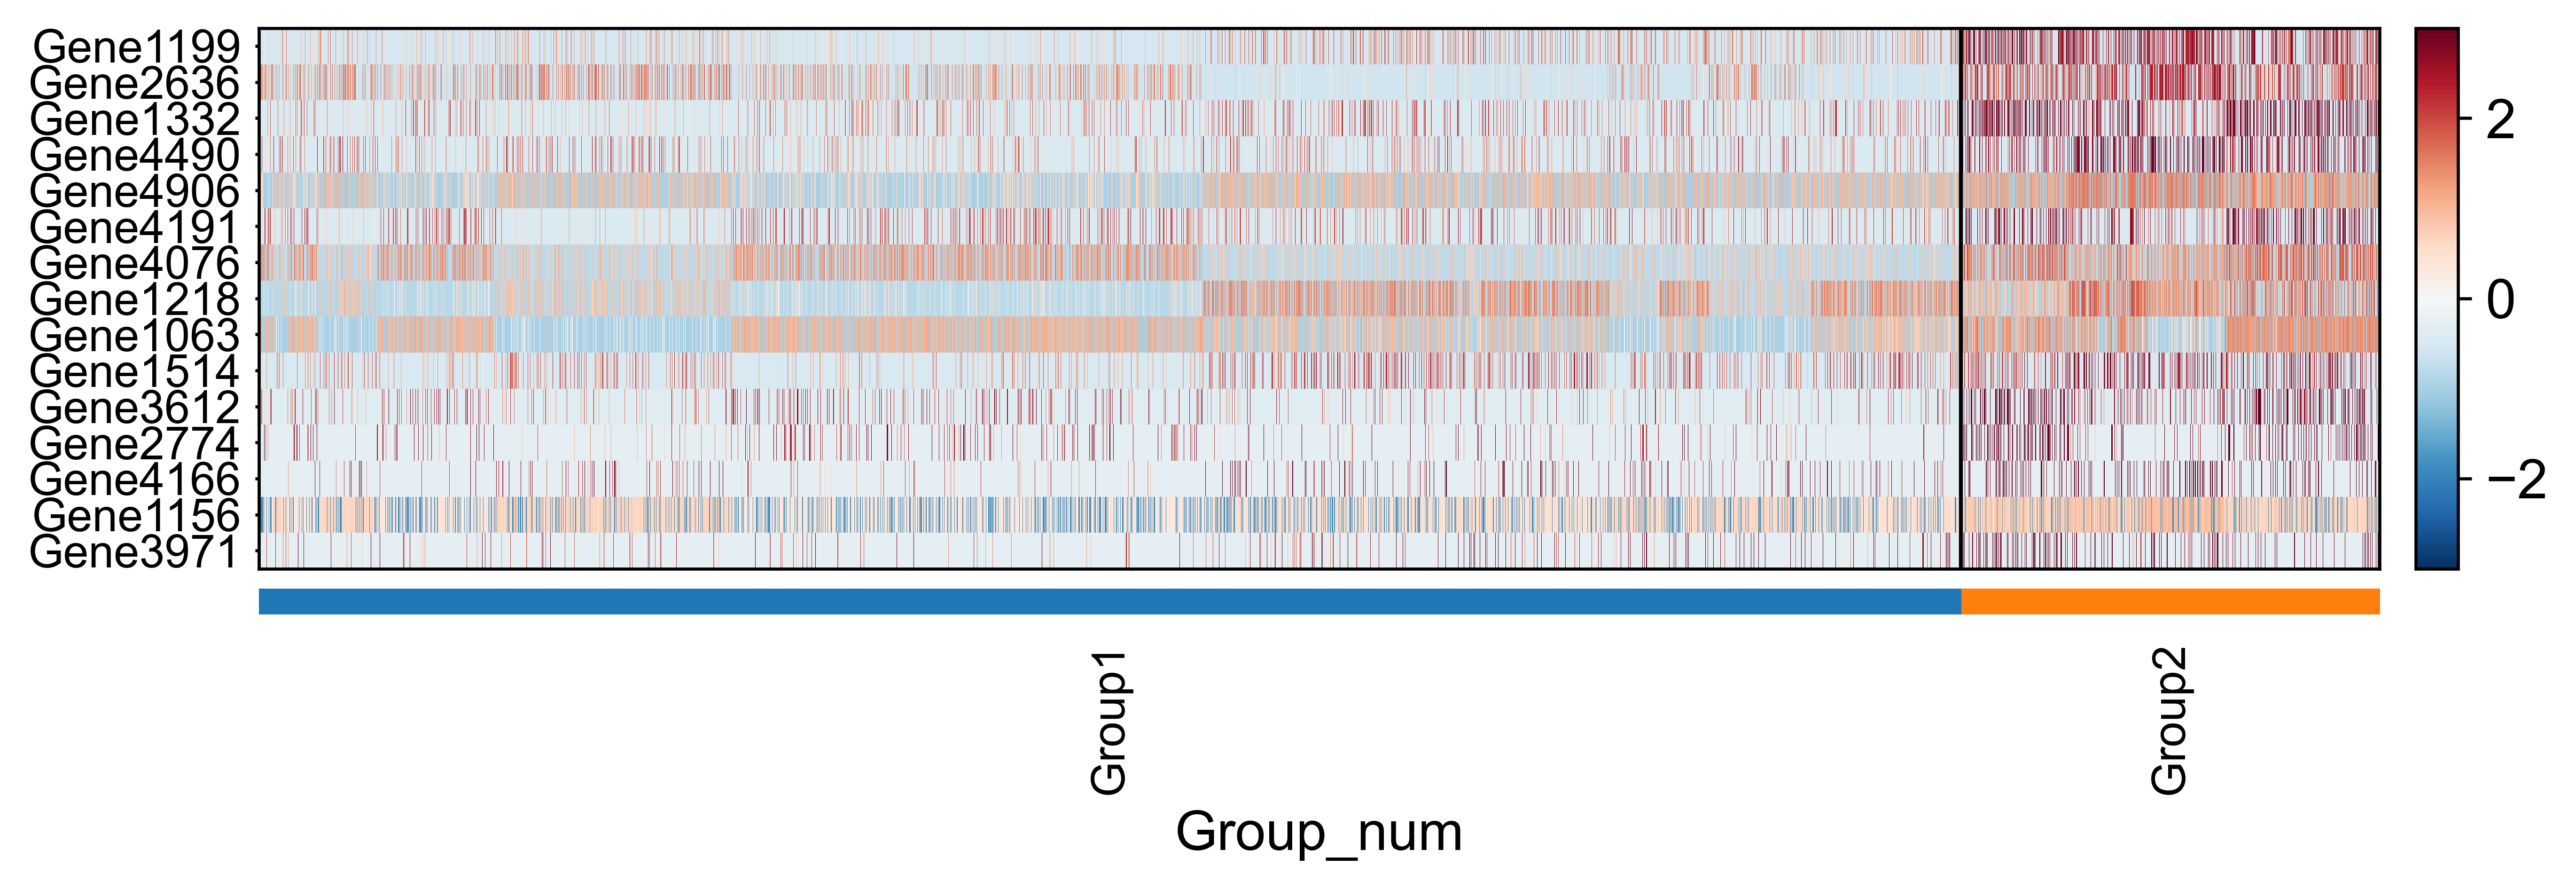

In [274]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
fig = plt.figure()

sc.pl.heatmap(adata_int, uniq_gene_xai[:15], groupby = "Group_num", show_gene_labels=True, layer = "X_raw_scaled", swap_axes = True, vmin = -3, vmax = 3, cmap = "RdBu_r")


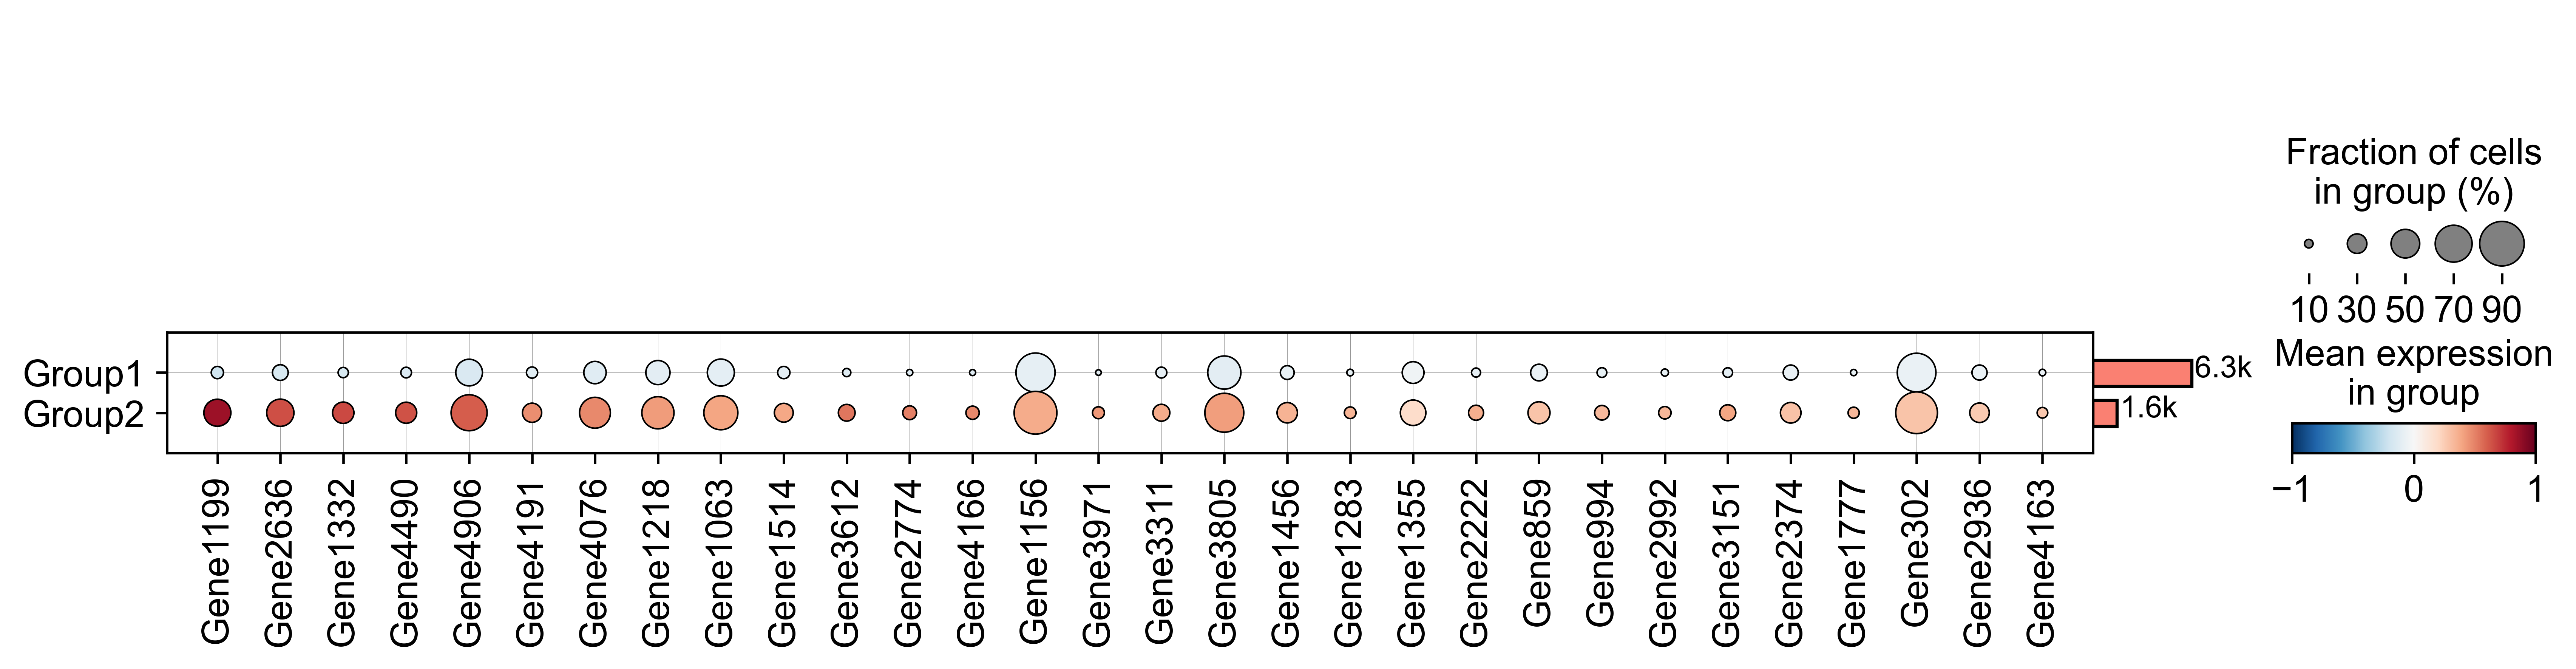

In [294]:
dotplot = sc.pl.dotplot(adata_int, uniq_gene_xai[:30], groupby=["Group_num"], layer = "X_raw_scaled", swap_axes = False, vmin = -1., vmax = 1., return_fig=True).add_totals().style(grid=True, cmap = "RdBu_r", dot_edge_lw=0.5,
x_padding=0.8, y_padding=1.0).show()

In [107]:
# setup_seed(8)

# plot_3_df = avg_3_df_scaled[top_100_3[:10]]
# # std_scaler = StandardScaler()
 
# # df_scaled = std_scaler.fit_transform(plot_3_df.values)
# # df_scaled = pd.DataFrame(df_scaled, columns=plot_3_df.columns, index = plot_3_df.index)
# # plt.subplots(figsize=(30,6))
# g = sns.clustermap(plot_3_df.transpose(), vmin = -3, vmax = 3, cmap = "RdBu_r", xticklabels=True, square=True, yticklabels=True, cbar_kws={'label': 'Scaled Association Score', "drawedges": False}
#                   , dendrogram_ratio = 0.1, cbar=True, linewidth=.4, cbar_pos=(0.02, 0.7, 0.02, 0.2))
# g.ax_cbar.grid(False)
# g.ax_heatmap.grid(False)
# g.ax_heatmap.set_aspect('equal')
# # g.cax.remove()

# # g = sns.clustermap(data=corr_s, annot=True, fmt='d',cmap = "Blues")
# g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 20)
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)

# hm = g.ax_heatmap.get_position()
# col = g.ax_col_dendrogram.get_position()
# g.ax_col_dendrogram.set_position([hm.x0, hm.y0 + hm.height, hm.width, col.height * 0.7])
# row = g.ax_row_dendrogram.get_position()
# g.ax_row_dendrogram.set_position([hm.x0 - row.width * 0.7, hm.y0, row.width * 0.7, hm.height])

# # plt.title("3'")
# plt.show()

In [108]:
# # access the heatmap axis
# ax = g.ax_heatmap

# # get the x axis labels
# x_axis_labels = [label.get_text() for label in ax.get_xticklabels()]
# y_axis_labels = [label.get_text() for label in ax.get_yticklabels()]
# # x_axis_labels

In [109]:
# raw_df_gene = adata_int.to_df(layer = "X_raw_scaled")
# raw_df_gene["CellType"] = adata_int.obs["CellType"]
# raw_df_gene["batch"] = adata_int.obs["batch"]
# plot_raw_df = raw_df_gene.groupby(["CellType", "batch"]).mean()
# plot_raw_df = plot_raw_df[y_axis_labels]

# fig, ax = plt.subplots(figsize=(10,15))
# g = sns.heatmap(plot_raw_df.loc[x_axis_labels], linewidth=.4, ax=ax, vmin = -3, vmax = 3, cmap = "RdBu_r", square =  True, xticklabels=True, yticklabels=True, cbar_kws={'label': 'mean expression', "shrink": .90, "pad": 0.01}, cbar=False)
# g.grid(False)
# g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 20)
# g.set_yticklabels(g.get_yticklabels(), fontsize = 20, rotation=0)
# # plt.yticks(rotation=90)
# # plt.gca().yaxis.tick_right()
# # plt.gca().tick_params(axis='y', which='major', labelsize=8)
# # plt.title("3'")
# plt.show()

In [110]:
# raw_df_gene = adata_int.to_df(layer = "X_corrected_scaled")
# raw_df_gene["CellType"] = adata_int.obs["CellType"]
# raw_df_gene["batch"] = adata_int.obs["batch"]
# plot_raw_df = raw_df_gene.groupby(["CellType", "batch"]).mean()
# plot_raw_df = plot_raw_df[y_axis_labels]

# fig, ax = plt.subplots(figsize=(10,15))
# g = sns.heatmap(plot_raw_df.loc[x_axis_labels], linewidth=.4, ax=ax, vmin = -3, vmax = 3, cmap = "RdBu_r", square =  True, xticklabels=True, yticklabels=True, cbar_kws={'label': 'mean expression', "shrink": .90, "pad": 0.01}, cbar=False)
# g.grid(False)
# g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 20)
# g.set_yticklabels(g.get_yticklabels(), fontsize = 20, rotation=0)
# # plt.yticks(rotation=90)
# # plt.gca().yaxis.tick_right()
# # plt.gca().tick_params(axis='y', which='major', labelsize=8)
# # plt.title("3'")
# plt.show()